In [1184]:
import numpy as np
from xrdc import xrdutils as xdu
from xrdc import simulation as sim

from xrdc import simulation
from xrdc import datasets as xd
import matplotlib.pyplot as plt

from xrdc import featurization as feat
from xrdc import source_separation as sep
from xrdc import peak_fitting as pf
from xrdc.datasets import d2d

def sample_peak_intensity():
    return np.random.uniform()

# https://stackoverflow.com/questions/35282456/find-local-maximums-in-numpy-array
import pandas as pd
from scipy.signal import argrelextrema

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


def get_ridges(orig, axis = 1):
    # determine the indices of the local maxima
    max_ind = argrelextrema(orig, np.greater, axis = axis)
#     max_ind_2 = argrelextrema(orig, np.greater, axis = 0)
#     max_ind = np.hstack((max_ind[0], max_ind_2[0])), np.hstack((max_ind[1], max_ind_2[1]))
    
    edges = np.zeros_like(orig)
    edges[max_ind] = 1
    return edges

def shuffle(bin_img, size = 1):
    ret = np.zeros_like(bin_img)
    for s in range(-size, size + 1):
        ret += np.roll(bin_img, s, axis = 0)
        ret += np.roll(bin_img, s, axis = 1)
    return np.sign(ret)

In [1185]:
from importlib import reload
from functools import reduce
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list, cut_tree, to_tree
from copy import deepcopy
from sklearn.cluster import AgglomerativeClustering

reload(feat)

<module 'xrdc.featurization' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py'>

In [5]:
patterns = d2d.patterns
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .25,  threshold = 50, smooth_q = 1.7)
background = slow_q

(0, 0)


In [8]:
# labeled, feature_masks, activations, activations_n0, activations_n1 = feat.get_ridge_features(patterns,
#    smooth_ax1 = 'FWHM', smooth_ax0 = 2, threshold_percentile = 50, thicken = True, size_thresh = 2, bgsub=False,
#     log_scale_features = False, fwhm_finder=fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
#     flood_threshold=.95)

# labeled, feature_masks, activations, activations_n0, activations_n1 = feat.get_ridge_features(patterns,
#    smooth_ax1 = 'FWHM', smooth_ax0 = 2, threshold_percentile = 50, thicken = True,
#     size_thresh = 30,
#     bgsub=False, log_scale_features = False, fwhm_finder=lambda x: 5, do_flood_thicken = False, max_size_flood = 20,
#     flood_threshold=.95, a = 2, b = 3);

In [6]:
from scipy.ndimage.filters import gaussian_filter as gf

Peak at 69, start iteration with error = 0.5545020976281996
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231

Peak at 207, iteration 0: error = 320.66815944623033
bounds ([-29.8, -6336.690450537386, 0, 0, 0], [625.8, inf, inf, 149.0, 149.0])
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 

/home/ollie/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


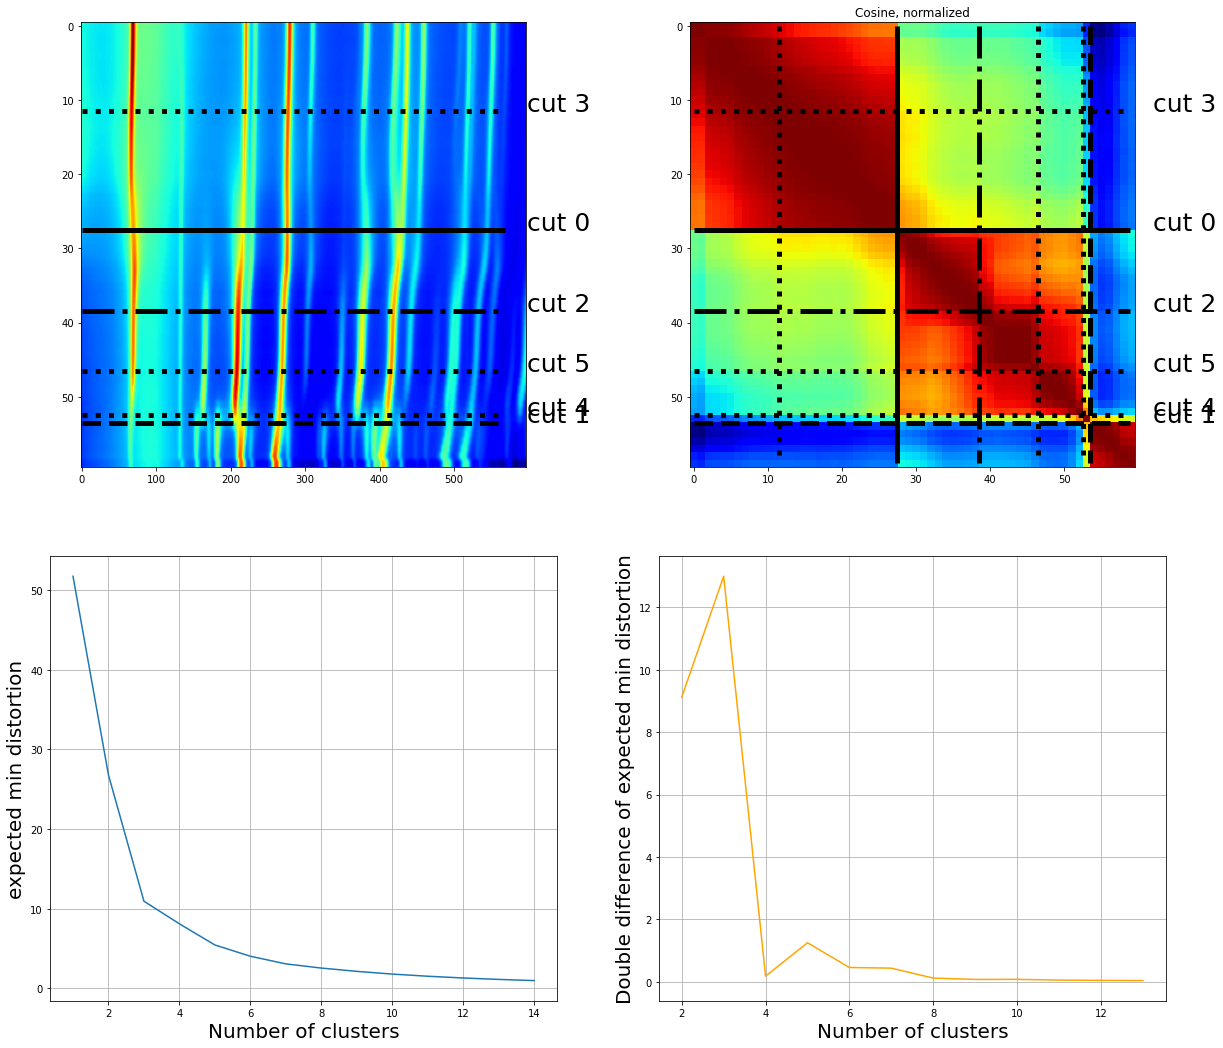

In [7]:
def default_featurize(patterns_pp):
    #patterns_pp = gf(patterns, (1, 1.7))
    labeled, feature_masks, activations, norm_, activations_n1 = feat.get_ridge_features(
        patterns_pp,
       smooth_ax1 = 'FWHM', smooth_ax0 = 1, threshold_percentile = 75, thicken = True, size_thresh = 5, bgsub=False,
        log_scale_features = False, fwhm_finder=feat.fwhm_finder, do_flood_thicken = False, max_size_flood = 20,
        thicken_ax0 = 0, thicken_ax1 = 1, flood_threshold=.95, smooth_factor_ax1 = .125)
    return labeled, feature_masks, activations, norm_, activations_n1

patterns_pp_simple = fast_q * (fast_q > 0)
labeled_simple, feature_masks_simple, activations_simple, _norm, activations_n1_simple =\
    default_featurize(patterns_pp_simple);
# straightened_heatmap_simple = feat.get_peakshift_corrected_heatmap(patterns_pp_simple, activations_simple, labeled_simple)

def get_activations(patterns_pp_simple):
    activations_n1_simple = feat.norm((feature_masks_simple * patterns_pp_simple).sum(axis = 2), axis = 1)
    return activations_n1_simple

act = get_activations(fast_q * (fast_q > 0))

simtype = 'Cosine'
scaling = 'log'
linkage = 'ward'
ctype = 'agglom'

feature_csims1, o_cuts = feat.sims_with_boundaries(patterns, act, act, n = 7, simtype = simtype, extra_label='',
                    ctype = ctype, linkage = linkage, affinity = 'euclidean')

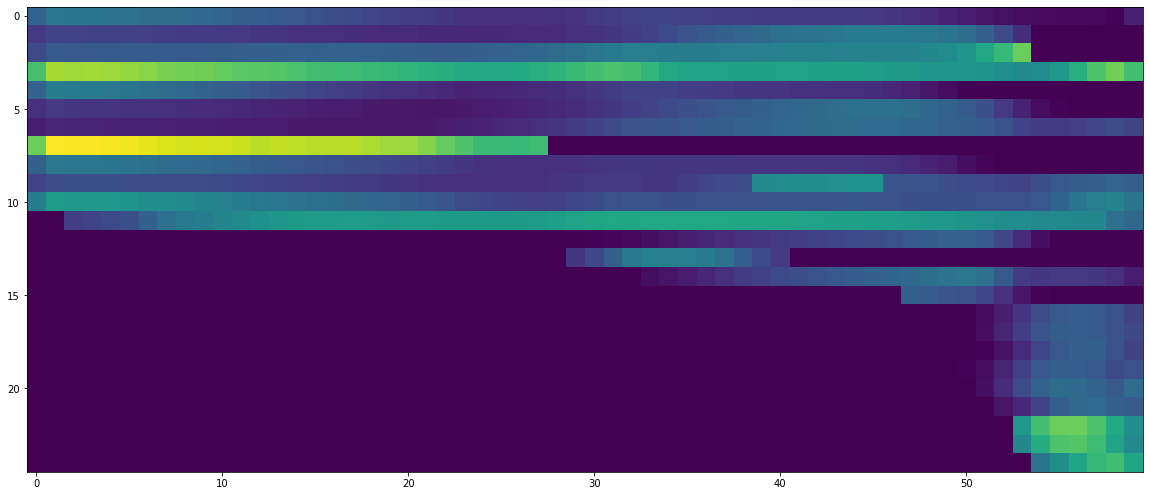

In [9]:
plt.imshow(act)

In [1187]:
fsub_stop_2d = pf.curvefit_2d((patterns - 0), stdratio_threshold = 2, noise_estimate = fast_T,
                   background = background, bg_shift_pos = False)

numBlocks: 357, dataPts/Block: 1.6722689075630253
[  0.  34. 126. 182. 229. 262. 296. 341. 407. 429. 447. 500. 511. 538.
 566. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 34.0], [34.0, 126.0], [126.0, 182.0], [182.0, 229.0], [229.0, 262.0], [262.0, 296.0], [296.0, 341.0], [341.0, 407.0], [407.0, 429.0], [429.0, 447.0], [447.0, 500.0], [500.0, 511.0], [511.0, 538.0], [538.0, 566.0], [566.0, 596.0]]}
running a single process
Peak at 1, start iteration with error = 0.405102059239611
0.4481095909584606
Peak at 70, start iteration with error = 0.5708371891781829
4.631350798179307
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125]
Peak at 70, iteration

Peak at 133, start iteration with error = 0.5577958665490299
31.758596146354847
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184]
Peak at 133, iteration 0: error = 1.2988126151998254
1.4292323792836048
bounds ([123.1, -126.44004983317313, 0, 0, 0], [186.9, inf, inf, 14.5, 14.5])
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184]
Peak at 222, start iteration with error = 0.9354609245926422
171.68595804988678
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228]
Peak at 222, iteration 0: er

/home/ollie/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated



Peak at 460, start iteration with error = 0.5590222480399517
143.24091000663398
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499]
Peak at 460, iteration 0: error = 13.059337526184372
9.992524634904633
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499]
Peak at 460, iteration 1: error = 6.680571773822768
3.2900789544663236
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499]
Peak at 460, iteration 2: error = 7.895731929000978
2.7013788200702
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 4

Peak at 133, start iteration with error = 0.26554610313845334
32.13091815662113
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181]
Peak at 133, iteration 0: error = 2.2133547167708243
2.265593057529672
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181]
Peak at 133, iteration 1: error = 2.2133545638921825
2.265593057529671
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181]
Peak at 133, iteration 2: error = 2.213354550982117
2.2655930575298546
[126 127 128 129 130

Peak at 460, start iteration with error = 0.7051486005977157
247.45367867760385
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486]
Peak at 460, iteration 0: error = 16.80009241309303
18.232067479400786
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486]
Peak at 460, iteration 1: error = 5.129257990134382
5.163485498878636
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486]
Peak at 460, iteration 2: error = 6.438303615981814
3.7041622403627033
[447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484 485 486]
Peak at 460, iteration 3: error = 0.7534113826864004

Peak at 134, start iteration with error = 0.25699086614165967
65.80411487214319
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183]
Peak at 134, iteration 0: error = 2.49294385822975
5.907342571476623
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183]
Peak at 134, iteration 1: error = 4.197167182434536
4.495982216995278
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183]
Peak at 134, iteration 2: error = 4.197167180269248
4.495982216997968


Peak at 424, iteration 1: error = 3.998069122595787
6.458386326660994
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429]
Peak at 424, iteration 2: error = 8.186716026406375
4.652664866044042
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429]
Peak at 424, iteration 3: error = 9.908457149938306
bounds ([404.85, -1066.751518827226, 0, 0, 0, 404.85, -1066.751518827226, 0, 0, 0, 404.85, -1066.751518827226, 0, 0, 0, 404.85, -1066.751518827226, 0, 0, 0], [430.15, inf, inf, 5.75, 5.75, 430.15, inf, inf, 5.75, 5.75, 430.15, inf, inf, 5.75, 5.75, 430.15, inf, inf, 5.75, 5.75])
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429]
Peak at 438, start iteration with error = 0.6499981533983386
576.1044928420425
[430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446]
Peak at 438, iteration 0: error = 0.3040242710891426
81.14255047136683
[430 431 43

Peak at 70, start iteration with error = 0.574859714267638
243.2064181066456
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126]
Peak at 70, iteration 0: error = 26.631353179783297
7.990528409731749
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126]
Peak at 70, iteration 1: error = 15.709368524585845
6.528389173386444
[ 34  35  36  37  38  39 

Peak at 383, iteration 2: error = 11.69537427360556
4.308990769700991
[339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374
 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 399 400 401 402 403 404 405]
Peak at 383, iteration 3: error = 11.69537507925341
bounds ([335.7, -1007.8625617452295, 0, 0, 0, 335.7, -1007.8625617452295, 0, 0, 0, 335.7, -1007.8625617452295, 0, 0, 0, 335.7, -1007.8625617452295, 0, 0, 0], [408.3, inf, inf, 16.5, 16.5, 408.3, inf, inf, 16.5, 16.5, 408.3, inf, inf, 16.5, 16.5, 408.3, inf, inf, 16.5, 16.5])
[339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374
 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392
 393 394 395 396 397 398 399 400 401 402 403 404 405]
Peak at 423, start iteration with error = 0.815510172066

Peak at 571, iteration 1: error = 1.7959452510924345
3.0983949283852987
[566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 571, iteration 2: error = 2.161592499080705
2.6618722866813793
[566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 571, iteration 3: error = 0.8341224808812844
bounds ([564.55, -104.54218357353949, 0, 0, 0, 564.55, -104.54218357353949, 0, 0, 0, 564.55, -104.54218357353949, 0, 0, 0, 564.55, -104.54218357353949, 0, 0, 0], [596.45, inf, inf, 7.25, 7.25, 596.45, inf, inf, 7.25, 7.25, 596.45, inf, inf, 7.25, 7.25, 596.45, inf, inf, 7.25, 7.25])
[566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591 592 593 594 595]
    ----Saving data for block between 1.00 - 33.00
    ----Saving data for block between 34.00 - 126.00
    ----Saving data for block between 127.00 - 

Peak at 280, start iteration with error = 0.850038978057937
274.3688668759734
[261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295]
Peak at 280, iteration 0: error = 5.119861458928507
3.4714213839356334
[261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295]
Peak at 280, iteration 1: error = 7.670145898287062
2.784642572299543
[261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295]
Peak at 280, iteration 2: error = 7.670145914170846
2.7846425722995427
[261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295]
Peak at 280, iteration 3: error = 7.670145911720099
bounds ([259.3, -5323.466494977832, 0, 0, 0, 259.3, -5323.466494977832, 0, 0, 0, 259.3

Peak at 521, start iteration with error = 0.808856533308531
455.36409708375567
[509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526
 527 528 529 530 531 532 533 534 535 536]
Peak at 521, iteration 0: error = 0.38378798209575354
87.61015550252262
[509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526
 527 528 529 530 531 532 533 534 535 536]
Peak at 521, iteration 1: error = 0.23438629475890585
44.85843421829103
[509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526
 527 528 529 530 531 532 533 534 535 536]
Peak at 521, iteration 2: error = 0.1381931091798863
34.44748758031419
[509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526
 527 528 529 530 531 532 533 534 535 536]
Peak at 521, iteration 3: error = 0.11194994552580939
bounds ([507.65, -627.0424585353345, 0, 0, 0, 507.65, -627.0424585353345, 0, 0, 0, 507.65, -627.0424585353345, 0, 0, 0, 507.65, -627.0424585353345, 0, 0, 0], [537.35, inf, inf, 6.75, 6.75, 537

Peak at 222, start iteration with error = 0.5327908745922633
460.15869049035615
[180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227]
Peak at 222, iteration 0: error = 4.583269047934611
2.780007166644607
[180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227]
Peak at 222, iteration 1: error = 5.47048136821238
2.067728733743046
[180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227]
Peak at 222, iteration 2: error = 5.5263869466447355
2.0675883063703293
[180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209

Peak at 438, iteration 2: error = 0.06038440368687443
14.88474380400384
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445]
Peak at 438, iteration 3: error = 0.04728163379257409
bounds ([427.15, -2093.743804560748, 0, 0, 0, 427.15, -2093.743804560748, 0, 0, 0, 427.15, -2093.743804560748, 0, 0, 0, 427.15, -2093.743804560748, 0, 0, 0], [445.85, inf, inf, 4.25, 4.25, 445.85, inf, inf, 4.25, 4.25, 445.85, inf, inf, 4.25, 4.25, 445.85, inf, inf, 4.25, 4.25])
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445]
Peak at 460, start iteration with error = 0.5504481930362535
382.26417749962087
[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497]
Peak at 460, iteration 0: error = 16.74925622999426
33.584339322206084
[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 4

Peak at 69, start iteration with error = 0.5619253117924188
322.7872718297579
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128]
Peak at 69, iteration 0: error = 27.102097303637123
10.182764737517422
[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128]
Peak at 69, iteration 1: error = 16.432602532645646
8.358510148710742
[ 34  3

Peak at 310, iteration 2: error = 4.110083042653986
2.6244591619929243
[301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318
 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336
 337 338 339 340 341 342 343 344 345 346 347 348 349]
Peak at 310, iteration 3: error = 4.110083078050845
bounds ([298.6, -541.8025121807373, 0, 0, 0, 298.6, -541.8025121807373, 0, 0, 0, 298.6, -541.8025121807373, 0, 0, 0, 298.6, -541.8025121807373, 0, 0, 0], [351.4, inf, inf, 12.0, 12.0, 351.4, inf, inf, 12.0, 12.0, 351.4, inf, inf, 12.0, 12.0, 351.4, inf, inf, 12.0, 12.0])
[301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318
 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336
 337 338 339 340 341 342 343 344 345 346 347 348 349]
Peak at 382, start iteration with error = 0.4914737137768198
140.54499969136316
[350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367
 368 369 370 371 372 373 374 375 376 377 378 379 380

numBlocks: 367, dataPts/Block: 1.6267029972752043
[  0.  34. 129. 179. 227. 261. 296. 351. 405. 428. 446. 485. 508. 535.
 565. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 34.0], [34.0, 129.0], [129.0, 179.0], [179.0, 227.0], [227.0, 261.0], [261.0, 296.0], [296.0, 351.0], [351.0, 405.0], [405.0, 428.0], [428.0, 446.0], [446.0, 485.0], [485.0, 508.0], [508.0, 535.0], [535.0, 565.0], [565.0, 596.0]]}
running a single process
Peak at 1, start iteration with error = 0.3267778677296177
19.040586512224976
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Peak at 1, iteration 0: error = 0.6190624310578039
2.3803749288239016
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Peak at 1, iteration 1: error = 0.6317521035070025
2.3803330917616217
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Peak at 1, iteration 2: err

Peak at 310, start iteration with error = 0.4395327238610477
98.05842148066195
[296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350]
Peak at 310, iteration 0: error = 2.9207226798049373
3.072078063340123
[296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350]
Peak at 310, iteration 1: error = 3.8222519200660408
2.340456942189356
[296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331
 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349
 350]
Peak at 310, iteration 2: error = 3.822251914925411
2.340456942189355
[296 297 298 299 300 301 302 303 3

Peak at 552, start iteration with error = 0.7479822423425031
123.34127927024436
[535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559 560 561 562 563 564]
Peak at 552, iteration 0: error = 0.3466913972712087
5.374537283651787
[535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559 560 561 562 563 564]
Peak at 552, iteration 1: error = 0.2817187564535796
3.493795413931528
[535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559 560 561 562 563 564]
Peak at 552, iteration 2: error = 0.16900946860029079
2.936037349519307
[535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559 560 561 562 563 564]
Peak at 552, iteration 3: error = 0.1666824919398873
bounds ([533.55, -685.7536330975213, 0, 0, 0, 533.55, -685.7536330975213, 0, 0, 0, 533.55, -685.7536330975213, 0, 0, 0, 533.55, -685.7536330975213, 0, 0, 0], [56

Peak at 279, iteration 0: error = 6.718735128465527
4.01070137611256
[261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296
 297 298 299 300]
Peak at 279, iteration 1: error = 9.31299865202914
3.170037650714539
[261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296
 297 298 299 300]
Peak at 279, iteration 2: error = 9.312994906613858
3.170037650714415
[261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296
 297 298 299 300]
Peak at 279, iteration 3: error = 9.312994885376138
bounds ([259.05, -4930.054868111105, 0, 0, 0, 259.05, -4930.054868111105, 0, 0, 0, 259.05, -4930.054868111105, 0, 0, 0, 259.05, -4930.054868111105, 0, 0, 0], [301.95, inf, inf, 9.75, 9.75, 301.95, inf, inf, 9.75, 9.75, 301.95, inf, inf, 9.75, 9.75,

Peak at 551, start iteration with error = 0.8701886793554021
158.72165909891362
[541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558
 559 560]
Peak at 551, iteration 0: error = 0.25560954942714303
13.376167838859265
[541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558
 559 560]
Peak at 551, iteration 1: error = 0.24193393256915763
10.246463994323205
[541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558
 559 560]
Peak at 551, iteration 2: error = 0.3579027382708707
4.788417446739118
[541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558
 559 560]
Peak at 551, iteration 3: error = 0.05301724393711353
bounds ([540.05, -649.5337594910718, 0, 0, 0, 540.05, -649.5337594910718, 0, 0, 0, 540.05, -649.5337594910718, 0, 0, 0, 540.05, -649.5337594910718, 0, 0, 0], [560.95, inf, inf, 4.75, 4.75, 560.95, inf, inf, 4.75, 4.75, 560.95, inf, inf, 4.75, 4.75, 560.95, inf, inf, 4.75, 4.75])
[541 542 543 544 545 546 547 548 549 

Peak at 279, start iteration with error = 0.7333383280605688
246.64902003914304
[253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294]
Peak at 279, iteration 0: error = 9.159847732367156
3.703260171616097
[253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294]
Peak at 279, iteration 1: error = 12.180642133634873
2.959002804931671
[253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294]
Peak at 279, iteration 2: error = 12.18064204669957
2.95900280493167
[253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294]
Peak at 279, iteration

Peak at 505, start iteration with error = 0.6301082382841782
39.61260419072127
[496 497 498 499 500 501 502 503 504 505 506]
Peak at 505, iteration 0: error = 2.380436645244186
1.449963007732054
bounds ([495.5, -76.80056237916278, 0, 0, 0], [506.5, inf, inf, 2.5, 2.5])
[496 497 498 499 500 501 502 503 504 505 506]
Peak at 520, start iteration with error = 0.7189708690198353
221.31115005766338
[507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524
 525 526 527 528 529 530 531 532 533]
Peak at 520, iteration 0: error = 0.30545799595447154
42.670579499562244
[507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524
 525 526 527 528 529 530 531 532 533]
Peak at 520, iteration 1: error = 0.20404678831292938
23.883813458301596
[507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524
 525 526 527 528 529 530 531 532 533]
Peak at 520, iteration 2: error = 0.20740619031918878
17.717569455566018
[507 508 509 510 511 512 513 514 515 516 517 518 519

Peak at 136, iteration 1: error = 3.322766835779589
3.9664446792345855
[129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190]
Peak at 136, iteration 2: error = 3.4299190230359295
3.9653651636002927
[129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190]
Peak at 136, iteration 3: error = 3.429919022143776
bounds ([125.95, -279.24755905951497, 0, 0, 0, 125.95, -279.24755905951497, 0, 0, 0, 125.95, -279.24755905951497, 0, 0, 0, 125.95, -279.24755905951497, 0, 0, 0], [193.05, inf, inf, 15.25, 15.25, 193.05, inf, inf, 15.25, 15.25, 193.05, inf, inf, 15.25, 15.25, 193.05, inf, inf, 15.25, 15.25])
[129 13

Peak at 437, iteration 0: error = 0.4051548389087521
45.795545023181255
[427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444]
Peak at 437, iteration 1: error = 0.05738787304145981
7.485553361968788
[427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444]
Peak at 437, iteration 2: error = 0.0330660723720482
3.7534730447236258
[427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444]
Peak at 437, iteration 3: error = 0.026453152974532695
bounds ([426.15, -1998.7405763657248, 0, 0, 0, 426.15, -1998.7405763657248, 0, 0, 0, 426.15, -1998.7405763657248, 0, 0, 0, 426.15, -1998.7405763657248, 0, 0, 0], [444.85, inf, inf, 4.25, 4.25, 444.85, inf, inf, 4.25, 4.25, 444.85, inf, inf, 4.25, 4.25, 444.85, inf, inf, 4.25, 4.25])
[427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444]
Peak at 458, start iteration with error = 0.5896121656142747
225.3786521523818
[445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 4

Peak at 1, iteration 0: error = 0.47930352847469626
1.7595139381646536
bounds ([-0.5, -76.04494583504527, 0, 0, 0], [32.5, inf, inf, 7.5, 7.5])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 68, start iteration with error = 0.6478308017724048
171.19354810720677
[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128]
Peak at 68, iteration 0: error = 22.029128971046596
5.851482567995298
[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  

Peak at 420, start iteration with error = 0.8690983110454077
118.53420145729861
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425 426 427]
Peak at 420, iteration 0: error = 5.476661832367369
13.146377702381512
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425 426 427]
Peak at 420, iteration 1: error = 11.832661827338883
8.723918674154325
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425 426 427]
Peak at 420, iteration 2: error = 16.352071578259558
6.16514592988351
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425 426 427]
Peak at 420, iteration 3: error = 1.3258557514698632
bounds ([402.85, -818.8531633073641, 0, 0, 0, 402.85, -818.8531633073641, 0, 0, 0, 402.85, -818.8531633073641, 0, 0, 0, 402.85, -818.8531633073641, 0, 0, 0], [428.15, inf, inf, 5.75, 5.75, 428.15, inf, inf, 5.75, 5.75, 428.15, inf, inf, 5.75, 5.75, 428.15, in

Peak at 68, start iteration with error = 0.6702981293521146
530.6601922553139
[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128]
Peak at 68, iteration 0: error = 22.190094501666128
18.71944099160202
[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128]
Peak at 68, iteration 1: error = 15.450009057863832
15.8088500

Peak at 419, start iteration with error = 0.8534176538245518
233.47392189599503
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425]
Peak at 419, iteration 0: error = 2.9873889684287858
36.83926295517736
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425]
Peak at 419, iteration 1: error = 20.292126276304064
19.92653978542189
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425]
Peak at 419, iteration 2: error = 3.000528977814902
16.19215337096012
[404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421
 422 423 424 425]
Peak at 419, iteration 3: error = 1.2876556092522151
bounds ([402.95, -792.204487538497, 0, 0, 0, 402.95, -792.204487538497, 0, 0, 0, 402.95, -792.204487538497, 0, 0, 0, 402.95, -792.204487538497, 0, 0, 0], [426.05, inf, inf, 5.25, 5.25, 426.05, inf, inf, 5.25, 5.25, 426.05, inf, inf, 5.25, 5.25, 426.05, inf, inf, 5.25, 5.25])
[404 405 406 40

Peak at 68, iteration 0: error = 22.53248046929409
8.875229963498606
[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128]
Peak at 68, iteration 1: error = 17.071420522601134
7.620225515863561
[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128]
Peak at 68, iteration 2: error = 17.071420537338508
7.620225515863561
[

Peak at 379, start iteration with error = 0.6114482083322943
140.1849312250013
[349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402]
Peak at 379, iteration 0: error = 4.990241878608312
8.62689025256329
[349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402]
Peak at 379, iteration 1: error = 5.322880752134072
6.578592875514325
[349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402]
Peak at 379, iteration 2: error = 5.322880750833414
6.578592875514324
[349 350 351 352 353 354 355 356 357 358 359 360 361

Peak at 1, iteration 0: error = 0.5259096642840911
2.461635094205035
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 1, iteration 1: error = 0.561998565858174
2.461966313996334
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 1, iteration 2: error = 0.5620828463548267
2.461971031279067
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 1, iteration 3: error = 0.5621623305761341
bounds ([-0.5, -92.76370066048344, 0, 0, 0, -0.5, -92.76370066048344, 0, 0, 0, -0.5, -92.76370066048344, 0, 0, 0, -0.5, -92.76370066048344, 0, 0, 0], [32.5, inf, inf, 7.5, 7.5, 32.5, inf, inf, 7.5, 7.5, 32.5, inf, inf, 7.5, 7.5, 32.5, inf, inf, 7.5, 7.5])
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Peak at 68, start iteration with error = 0.6543474623459193
356.17393512492436
[ 32  33  34  35  36  37

Peak at 277, iteration 2: error = 29.558055879253498
10.43722155864689
[259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299]
Peak at 277, iteration 3: error = 27.13763224722637
bounds ([257.0, -4374.906737555837, 0, 0, 0, 257.0, -4374.906737555837, 0, 0, 0, 257.0, -4374.906737555837, 0, 0, 0, 257.0, -4374.906737555837, 0, 0, 0], [301.0, inf, inf, 10.0, 10.0, 301.0, inf, inf, 10.0, 10.0, 301.0, inf, inf, 10.0, 10.0, 301.0, inf, inf, 10.0, 10.0])
[259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299]
Peak at 308, start iteration with error = 0.38919749333921727
97.0809265883541
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345 346

    ----Saving data for block between 1.00 - 31.00
    ----Saving data for block between 32.00 - 128.00
    ----Saving data for block between 129.00 - 185.00
    ----Saving data for block between 186.00 - 224.00
    ----Saving data for block between 225.00 - 258.00
    ----Saving data for block between 259.00 - 299.00
    ----Saving data for block between 300.00 - 346.00
    ----Saving data for block between 347.00 - 403.00
    ----Saving data for block between 404.00 - 426.00
    ----Saving data for block between 427.00 - 444.00
    ----Saving data for block between 445.00 - 492.00
    ----Saving data for block between 493.00 - 538.00
    ----Saving data for block between 539.00 - 595.00
done
numBlocks: 377, dataPts/Block: 1.5835543766578248
[  0.  31. 129. 185. 226. 259. 296. 348. 404. 425. 448. 493. 533. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 31.0], [31.0, 129.0], [129.0, 185.0], [185.0, 226.0], [226.0, 259.0], [259.0, 296.0], [296.0, 348.0], [348.0, 404.0

Peak at 232, iteration 0: error = 6.897287573552516
20.985919219738193
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258]
Peak at 232, iteration 1: error = 12.161653404977363
10.59742507578928
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258]
Peak at 232, iteration 2: error = 13.58897497765537
9.476705421616266
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258]
Peak at 232, iteration 3: error = 13.588947286764668
bounds ([224.4, -798.8274076785036, 0, 0, 0, 224.4, -798.8274076785036, 0, 0, 0, 224.4, -798.8274076785036, 0, 0, 0, 224.4, -798.8274076785036, 0, 0, 0], [259.6, inf, inf, 8.0, 8.0, 259.6, inf, inf, 8.0, 8.0, 259.6, inf, inf, 8.0, 8.0, 259.6, inf, inf, 8.0, 8.0])
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 2

Peak at 457, iteration 2: error = 10.954931602473255
5.201502675562463
[448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484 485 486 487 488 489 490 491 492]
Peak at 457, iteration 3: error = 10.955184959583708
bounds ([445.8, -777.2649342943319, 0, 0, 0, 445.8, -777.2649342943319, 0, 0, 0, 445.8, -777.2649342943319, 0, 0, 0, 445.8, -777.2649342943319, 0, 0, 0], [494.2, inf, inf, 11.0, 11.0, 494.2, inf, inf, 11.0, 11.0, 494.2, inf, inf, 11.0, 11.0, 494.2, inf, inf, 11.0, 11.0])
[448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484 485 486 487 488 489 490 491 492]
Peak at 518, start iteration with error = 0.8435714210186023
87.2655836301111
[493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528
 529 530 531

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 220, iteration 2: error = 2.8702543275485572
5.800221493707226
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225]
Peak at 220, iteration 3: error = 3.896588402305255
bounds ([183.0, -2375.135066970804, 0, 0, 0, 183.0, -2375.135066970804, 0, 0, 0, 183.0, -2375.135066970804, 0, 0, 0, 183.0, -2375.135066970804, 0, 0, 0], [227.0, inf, inf, 10.0, 10.0, 227.0, inf, inf, 10.0, 10.0, 227.0, inf, inf, 10.0, 10.0, 227.0, inf, inf, 10.0, 10.0])
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225]
Peak at 232, start iteration with error = 0.594533225386682
376.7214306311211
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251

[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445 446 447]
Peak at 435, iteration 2: error = 0.021984932053853747
2.8368050316913553
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445 446 447]
Peak at 435, iteration 3: error = 0.012680565196881767
bounds ([423.9, -1932.3736967285324, 0, 0, 0, 423.9, -1932.3736967285324, 0, 0, 0, 423.9, -1932.3736967285324, 0, 0, 0, 423.9, -1932.3736967285324, 0, 0, 0], [448.1, inf, inf, 5.5, 5.5, 448.1, inf, inf, 5.5, 5.5, 448.1, inf, inf, 5.5, 5.5, 448.1, inf, inf, 5.5, 5.5])
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445 446 447]
Peak at 457, start iteration with error = 0.4993611119464349
143.92207051150277
[448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465
 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484 485 486 487 488 489 490 491 492]
Peak at 457, iteration 0: error = 8.276689319536311
13

Peak at 68, iteration 3: error = 12.881840490847434
bounds ([26.15, -4627.531658900578, 0, 0, 0, 26.15, -4627.531658900578, 0, 0, 0, 26.15, -4627.531658900578, 0, 0, 0, 26.15, -4627.531658900578, 0, 0, 0], [132.85, inf, inf, 24.25, 24.25, 132.85, inf, inf, 24.25, 24.25, 132.85, inf, inf, 24.25, 24.25, 132.85, inf, inf, 24.25, 24.25])
[ 31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128]
Peak at 136, start iteration with error = 0.23409042324634313
214.2588911032463
[129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 17

Peak at 379, start iteration with error = 0.5679794999989909
118.91830442948468
[347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403]
Peak at 379, iteration 0: error = 5.423516716524293
9.98943554995215
[347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403]
Peak at 379, iteration 1: error = 6.054863081850132
7.796290060124313
[347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403]
Peak at 379, iteration 2: error = 6.054863090733023
7.796290060124312
[347 348 349

    ----Saving data for block between 1.00 - 30.00
    ----Saving data for block between 31.00 - 128.00
    ----Saving data for block between 129.00 - 183.00
    ----Saving data for block between 184.00 - 224.00
    ----Saving data for block between 225.00 - 258.00
    ----Saving data for block between 259.00 - 299.00
    ----Saving data for block between 300.00 - 346.00
    ----Saving data for block between 347.00 - 403.00
    ----Saving data for block between 404.00 - 425.00
    ----Saving data for block between 426.00 - 447.00
    ----Saving data for block between 448.00 - 491.00
    ----Saving data for block between 492.00 - 531.00
    ----Saving data for block between 532.00 - 595.00
done
numBlocks: 392, dataPts/Block: 1.5229591836734695
[  0.  22. 129. 184. 225. 259. 300. 346. 405. 426. 444. 491. 538. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 22.0], [22.0, 129.0], [129.0, 184.0], [184.0, 225.0], [225.0, 259.0], [259.0, 300.0], [300.0, 346.0], [346.0, 405.0

Peak at 307, start iteration with error = 0.35694633813129856
34.80275023142002
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345]
Peak at 307, iteration 0: error = 1.648181433763644
2.002354472418144
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345]
Peak at 307, iteration 1: error = 2.9772216602865806
1.4224741851663554
bounds ([297.75, -219.10597140006723, 0, 0, 0, 297.75, -219.10597140006723, 0, 0, 0], [347.25, inf, inf, 11.25, 11.25, 347.25, inf, inf, 11.25, 11.25])
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345]
Peak at 379, start iteration with error = 0.49523141776801083


    ----Saving data for block between 1.00 - 21.00
    ----Saving data for block between 22.00 - 128.00
    ----Saving data for block between 129.00 - 183.00
    ----Saving data for block between 184.00 - 224.00
    ----Saving data for block between 225.00 - 258.00
    ----Saving data for block between 259.00 - 299.00
    ----Saving data for block between 300.00 - 345.00
    ----Saving data for block between 346.00 - 404.00
    ----Saving data for block between 405.00 - 425.00
    ----Saving data for block between 426.00 - 443.00
    ----Saving data for block between 444.00 - 490.00
    ----Saving data for block between 491.00 - 537.00
    ----Saving data for block between 538.00 - 595.00
done
numBlocks: 391, dataPts/Block: 1.526854219948849
[  0.  31. 125. 170. 226. 259. 300. 346. 405. 424. 444. 490. 532. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 31.0], [31.0, 125.0], [125.0, 170.0], [170.0, 226.0], [226.0, 259.0], [259.0, 300.0], [300.0, 346.0], [346.0, 405.0]

Peak at 307, start iteration with error = 0.44517160072761675
37.047874738231414
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345]
Peak at 307, iteration 0: error = 1.326624493634716
2.0813760702579382
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345]
Peak at 307, iteration 1: error = 2.131467634128812
1.6655787983012142
bounds ([297.75, -207.34670727543232, 0, 0, 0, 297.75, -207.34670727543232, 0, 0, 0], [347.25, inf, inf, 11.25, 11.25, 347.25, inf, inf, 11.25, 11.25])
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345]
Peak at 379, start iteration with error = 0.5642104541150065


Peak at 548, iteration 3: error = 7.771647856383922
bounds ([528.85, -451.92731190163715, 0, 0, 0, 528.85, -451.92731190163715, 0, 0, 0, 528.85, -451.92731190163715, 0, 0, 0, 528.85, -451.92731190163715, 0, 0, 0], [598.15, inf, inf, 15.75, 15.75, 598.15, inf, inf, 15.75, 15.75, 598.15, inf, inf, 15.75, 15.75, 598.15, inf, inf, 15.75, 15.75])
[532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549
 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585
 586 587 588 589 590 591 592 593 594 595]
    ----Saving data for block between 1.00 - 30.00
    ----Saving data for block between 31.00 - 124.00
    ----Saving data for block between 125.00 - 169.00
    ----Saving data for block between 170.00 - 225.00
    ----Saving data for block between 226.00 - 258.00
    ----Saving data for block between 259.00 - 299.00
    ----Saving data for block between 300.00 - 345.00
    ----Saving data f

Peak at 232, iteration 3: error = 14.628701420863191
bounds ([224.4, -746.6443202709569, 0, 0, 0, 224.4, -746.6443202709569, 0, 0, 0, 224.4, -746.6443202709569, 0, 0, 0, 224.4, -746.6443202709569, 0, 0, 0], [259.6, inf, inf, 8.0, 8.0, 259.6, inf, inf, 8.0, 8.0, 259.6, inf, inf, 8.0, 8.0, 259.6, inf, inf, 8.0, 8.0])
[226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258]
Peak at 277, start iteration with error = 0.893217983119335
429.0229668735571
[259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299]
Peak at 277, iteration 0: error = 5.436496959608243
10.432959694471474
[259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299]
Peak at 277, iteration 1: error = 2.8531253852829233
8.20361551

Peak at 516, start iteration with error = 0.7505040504580491
95.22571724457416
[490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531]
Peak at 516, iteration 0: error = 3.083631658862553
15.060195749531932
[490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531]
Peak at 516, iteration 1: error = 6.2498118445229185
8.291015290155508
[490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 516, iteration 2: error = 6.122157470065777
8.48274971735545
[490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 51

Peak at 219, start iteration with error = 0.6390910130205801
184.50186280231674
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223]
Peak at 219, iteration 0: error = 33.26928687929761
11.161796693597122
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223]
Peak at 219, iteration 1: error = 8.816460780680247
6.374075692920352
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223]
Peak at 219, iteration 2: error = 10.759252052927545
4.482373725807037
[185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223]
Peak at 219, iteration 3: error = 11.524942324550446
bounds ([183.1,

Peak at 433, iteration 3: error = 0.03682982347869569
bounds ([423.1, -1620.640514136172, 0, 0, 0, 423.1, -1620.640514136172, 0, 0, 0, 423.1, -1620.640514136172, 0, 0, 0, 423.1, -1620.640514136172, 0, 0, 0], [442.9, inf, inf, 4.5, 4.5, 442.9, inf, inf, 4.5, 4.5, 442.9, inf, inf, 4.5, 4.5, 442.9, inf, inf, 4.5, 4.5])
[424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441
 442]
Peak at 455, start iteration with error = 0.5710911622553231
122.91896747968089
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487]
Peak at 455, iteration 0: error = 17.5242271811773
28.84540744599914
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484 485 486 487]
Peak at 455, iteration 1: error = 14.600959120280185
13.116461614685186
[443 444 445 4

Peak at 135, start iteration with error = 0.27326746192297413
59.29840448010651
[125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185]
Peak at 135, iteration 0: error = 0.9335596126345788
1.2137428001038164
bounds ([122.0, -323.6130317073406, 0, 0, 0], [188.0, inf, inf, 15.0, 15.0])
[125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185]
Peak at 219, start iteration with error = 0.6940893586575889
149.4213605968917
[186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223]
Peak at 219, iteration 0: error = 51.8

Peak at 433, start iteration with error = 0.5561874647702957
99.46179149957749
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 0: error = 0.30151135328813083
36.589591727915256
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 1: error = 0.13741008842337968
9.126029009909553
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 2: error = 0.13133430548953334
7.0981665787125925
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 3: error = 0.06333800762339788
bounds ([424.0, -1509.2464261511595, 0, 0, 0, 424.0, -1509.2464261511595, 0, 0, 0, 424.0, -1509.2464261511595, 0, 0, 0, 424.0, -1509.2464261511595, 0, 0, 0], [446.0, inf, inf, 5.0, 5.0, 446.0, inf, inf, 5.0, 5.0, 446.0, inf, inf, 5.0, 5.0, 446.0, inf, inf, 5.0, 5.0])
[425 426 427 428 429 430 431 432 

Peak at 135, start iteration with error = 0.37907544913656216
98.17852099571628
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 135, iteration 0: error = 2.3138226193805003
2.650274515914379
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 135, iteration 1: error = 2.9142512010626684
1.855950209929481
bounds ([126.35, -326.5894123545305, 0, 0, 0, 126.35, -326.5894123545305, 0, 0, 0], [162.65, inf, inf, 8.25, 8.25, 162.65, inf, inf, 8.25, 8.25])
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 170, start iteration with error = 0.43492439289965273
3.3575552966848234
[162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185]
Peak at 170, iteration 0: error = 0

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 433, start iteration with error = 0.5444428121736943
197.99952714856806
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 0: error = 0.3422039267542813
87.43767588228553
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 1: error = 0.21160654940400722
24.0481005607032
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 2: error = 0.10616385127468801
20.344655480350585
[425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445]
Peak at 433, iteration 3: error = 0.108071930640501
bounds ([424.0, -1422.133809565381, 0, 0, 0, 424.0, -1422.133809565381, 0, 0, 0, 424.0, -1422.133809565381, 0, 0, 0, 424.0, -1422.133809565381, 0, 0, 0], [446.0, inf, inf, 5.0, 5.0, 446.0, inf, inf, 5.0, 5.0, 446.0, inf

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 135, start iteration with error = 0.37766393466872533
60.02256459416373
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 135, iteration 0: error = 1.6655248349637695
1.605456972499828
bounds ([126.35, -321.4861222451319, 0, 0, 0], [162.65, inf, inf, 8.25, 8.25])
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
Peak at 170, start iteration with error = 0.4297410102192221
3.642459825959206
[162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185]
Peak at 170, iteration 0: error = 0.8673137473381601
0.6449069820647422
bounds ([160.85, -12.620869441324999, 0, 0, 0], [186.15, inf, inf, 5.75, 5.75])
[162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 18

Peak at 454, start iteration with error = 0.5820578925635541
84.31806695624664
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485]
Peak at 454, iteration 0: error = 26.353152101255876
25.56146115175606
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485]
Peak at 454, iteration 1: error = 20.504124778333104
11.496176701872688
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483 484 485]
Peak at 454, iteration 2: error = 24.92574490088378
8.866520395384773
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 47

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 135, start iteration with error = 0.402162125139689
151.525071132591
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
Peak at 135, iteration 0: error = 1.930848959657847
4.171444926759971
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
Peak at 135, iteration 1: error = 2.605585426820653
2.9575956411929933
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
Peak at 135, iteration 2: error = 3.0070384122042935
2.7695825322945207
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159]
Peak at 135, iteration 3: error = 3.158450810358115
bounds ([126.45, -324.8286792317167, 0, 0, 0, 12

Peak at 432, start iteration with error = 0.9192813047641263
325.4772975153599
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441
 442 443]
Peak at 432, iteration 0: error = 17.936892172808882
120.52305440495947
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441
 442 443]
Peak at 432, iteration 1: error = 64.94053825084163
61.10676297192834
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441
 442 443]
Peak at 432, iteration 2: error = 3.789465086694472
45.599172412187315
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441
 442 443]
Peak at 432, iteration 3: error = 8.766636350389293
bounds ([404.15, -1387.301824853

Peak at 135, start iteration with error = 0.4136474462839352
74.37227440318819
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158]
Peak at 135, iteration 0: error = 1.3301298570148676
1.7460634600994067
bounds ([126.5, -328.96940669918547, 0, 0, 0], [159.5, inf, inf, 7.5, 7.5])
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158]
Peak at 169, start iteration with error = 0.38413696328236346
5.420644090468675
[159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186]
Peak at 169, iteration 0: error = 1.6881614832543117
0.5681726984053488
bounds ([157.65, -21.283241531562112, 0, 0, 0], [187.35, inf, inf, 6.75, 6.75])
[159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186]
Peak at 218, start iteration with error = 0.8370947809765

Peak at 454, start iteration with error = 0.5444982653078935
68.52292096628831
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484]
Peak at 454, iteration 0: error = 19.52418749651152
18.48134849959582
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484]
Peak at 454, iteration 1: error = 32.633070624781126
9.040719273525038
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484]
Peak at 454, iteration 2: error = 8.381583754868261
6.536830066199963
[443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478
 479 480 481 482 483 484]
Peak at 454, iteration

Peak at 135, start iteration with error = 0.4156459326089304
82.98230681219836
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158]
Peak at 135, iteration 0: error = 2.2152992754462635
2.2742430879240567
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158]
Peak at 135, iteration 1: error = 2.8184251183860143
1.5096796533127994
bounds ([126.5, -335.4261951999929, 0, 0, 0, 126.5, -335.4261951999929, 0, 0, 0], [159.5, inf, inf, 7.5, 7.5, 159.5, inf, inf, 7.5, 7.5])
[128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158]
Peak at 169, start iteration with error = 0.48046490918853507
9.966093044865163
[159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186]
Peak at 169, iteration 0: error = 2.167414805002657
0.936601253

Peak at 453, start iteration with error = 0.5769815871337144
115.1847163345715
[442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484]
Peak at 453, iteration 0: error = 16.593340589740937
26.490495300215997
[442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484]
Peak at 453, iteration 1: error = 27.292140376496587
14.251677727653956
[442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484]
Peak at 453, iteration 2: error = 30.29862122241825
13.191844853766487
[442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459
 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477
 478 479 480 481 482 483 484]
Pe

Peak at 135, start iteration with error = 0.4047042747610603
162.06165393744854
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 0: error = 2.115820623208647
4.538062870559683
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 1: error = 2.671368932240281
3.1574834064471844
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 2: error = 2.925319638005518
3.0542865426199035
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 3: error = 2.9253195557656646
bounds ([122.35, -342.32969418264827, 0, 0, 0, 122.35, -342.32969418264827, 0, 0, 0, 122.35, -342.3

Peak at 427, start iteration with error = 0.9332491159533748
127.7932885971767
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437]
Peak at 427, iteration 0: error = 5.8071909131241535
8.801916049442449
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437]
Peak at 427, iteration 1: error = 1.5265743136726782
6.272828549448937
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437]
Peak at 427, iteration 2: error = 2.99754592935959
3.9809638273952532
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437]
Peak at 427, iteration 3: error = 4.119924349704578
bounds ([404.45, -1744.8692129172355, 0, 0, 0, 404.45, -1744.8692129172355, 0, 0, 0, 404.45, -1744.8692129172355, 0, 0, 0, 404.45, -1

Peak at 135, start iteration with error = 0.4410527063176783
147.06685768734678
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 0: error = 2.6382083699304895
4.4237992411108635
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 1: error = 3.3631647164292717
2.801659304115828
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 2: error = 1.7064991583183688
2.442316653483262
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 3: error = 2.0728160718892945
bounds ([122.35, -349.01856328594806, 0, 0, 0, 122.35, -349.01856328594806, 0, 0, 0, 122.35, -349

Peak at 427, start iteration with error = 0.9388542454292581
113.04637704353522
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439]
Peak at 427, iteration 0: error = 6.32166089722621
5.540398734520365
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439]
Peak at 427, iteration 1: error = 4.493797951851102
4.774171932988106
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439]
Peak at 427, iteration 2: error = 0.955010137254393
3.1804639793307574
[406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423
 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439]
Peak at 427, iteration 3: error = 0.9322083395680938
bounds ([404.35, -2004.62818552563, 0, 0, 0, 404.35, -2004.62818552563, 0, 0, 0, 404.35, -2004.628185

Peak at 135, start iteration with error = 0.4473306016949773
87.30737639976024
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 0: error = 2.575868406384766
3.6351883115283967
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 1: error = 4.667402706635189
2.3180010557275836
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 2: error = 5.126256457787516
2.1703524173782682
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
Peak at 135, iteration 3: error = 2.2981161650250663
bounds ([122.35, -353.4857699438255, 0, 0, 0, 122.35, -353.4857699438255, 0, 0, 0, 122.35, -353.485

[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483]
Peak at 451, iteration 1: error = 22.35882378606574
7.877886388359477
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483]
Peak at 451, iteration 2: error = 25.80609750505763
6.840402905491035
[440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457
 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475
 476 477 478 479 480 481 482 483]
Peak at 451, iteration 3: error = 6.06065026999082
bounds ([437.85, -469.1786342541756, 0, 0, 0, 437.85, -469.1786342541756, 0, 0, 0, 437.85, -469.1786342541756, 0, 0, 0, 437.85, -469.1786342541756, 0, 0, 0], [485.15, inf, inf, 10.75, 10.75, 485.15, inf, inf, 10.75, 10.75, 485.15, inf, inf, 10.75, 10.75, 485.15, inf, i

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 135, start iteration with error = 0.42630658475135214
132.8672525913203
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156]
Peak at 135, iteration 0: error = 3.517199836888591
10.345633121631513
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156]
Peak at 135, iteration 1: error = 7.071878203510861
7.818427049073739
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156]
Peak at 135, iteration 2: error = 10.020098835505413
6.5304695254179865
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156]
Peak at 135, iteration 3: error = 5.131118862474657
bounds ([125.55, -349.0471902741522, 0, 0, 0, 125.55, -349.0471902741522, 0, 

Peak at 514, start iteration with error = 0.473875490621403
34.69757332338592
[481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522]
Peak at 514, iteration 0: error = 18.372493340015538
5.848931750572291
[481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522]
Peak at 514, iteration 1: error = 25.50181078076754
4.1484282780395585
[481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522]
Peak at 514, iteration 2: error = 26.530362373465366
4.013973404587548
[481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522]
Peak at 514, iteratio

Peak at 169, start iteration with error = 0.44496952507859566
38.05276411248964
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187]
Peak at 169, iteration 0: error = 5.245711455115052
1.4852130407318413
bounds ([148.15, -185.93991544581195, 0, 0, 0], [188.85, inf, inf, 9.25, 9.25])
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187]
Peak at 215, start iteration with error = 0.8545361502142174
72.33730376320143
[188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222]
Peak at 215, iteration 0: error = 12.83724018837742
5.9955706836712315
[188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222]
Peak at 215, iteratio

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 541, start iteration with error = 0.5535870113601097
21.35455737735675
[523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 542 543 544 545 546 547 548 549]
Peak at 541, iteration 0: error = 8.443515052592213
1.747407132264644
bounds ([521.7, -385.0532067134393, 0, 0, 0], [550.3, inf, inf, 6.5, 6.5])
[523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 542 543 544 545 546 547 548 549]
Peak at 559, start iteration with error = 0.465629069713719
20.715002740741163
[550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 576 577 578 579 580 581]
Peak at 559, iteration 0: error = 4.3465712144015285
0.745880314434593
bounds ([548.45, -182.18243313890736, 0, 0, 0], [582.55, inf, inf, 7.75, 7.75])
[550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567
 568 569 570 571 572 573 574 575 5

Peak at 227, start iteration with error = 0.5222146788992515
94.4955254003547
[221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
Peak at 227, iteration 0: error = 7.680520745108602
20.418458908186054
[221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
Peak at 227, iteration 1: error = 47.786516301149405
10.55418641297668
[221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
Peak at 227, iteration 2: error = 59.610274317520506
9.793526517767287
[221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
Peak at 227, iteration 3: error = 28.717679791737886
bounds ([219.45, -1046.1735718036716, 0, 0, 0, 219.45, -1046.1735718036716, 0, 0, 0, 219.45, -1046.1735718036716, 0, 0, 0, 219.45, -

Peak at 511, iteration 2: error = 34.853774218626015
6.241836982816719
[473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490
 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508
 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526]
Peak at 511, iteration 3: error = 34.853774150946705
bounds ([470.35, -385.91896546938426, 0, 0, 0, 470.35, -385.91896546938426, 0, 0, 0, 470.35, -385.91896546938426, 0, 0, 0, 470.35, -385.91896546938426, 0, 0, 0], [528.65, inf, inf, 13.25, 13.25, 528.65, inf, inf, 13.25, 13.25, 528.65, inf, inf, 13.25, 13.25, 528.65, inf, inf, 13.25, 13.25])
[473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490
 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508
 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526]
Peak at 539, start iteration with error = 0.778740787409779
27.019887947535675
[527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 

Peak at 213, start iteration with error = 0.8147797809267552
114.72787372581071
[187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219]
Peak at 213, iteration 0: error = 12.737631715360697
2.0955210248460427
[187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219]
Peak at 213, iteration 1: error = 18.18490435685213
1.7379258425940582
bounds ([185.4, -4475.39749624033, 0, 0, 0, 185.4, -4475.39749624033, 0, 0, 0], [220.6, inf, inf, 8.0, 8.0, 220.6, inf, inf, 8.0, 8.0])
[187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219]
Peak at 226, start iteration with error = 0.48314959338099056
75.47079112486004
[220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
Peak at 226, iteratio

Peak at 537, start iteration with error = 0.7208113044299379
26.64526991324263
[525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542
 543 544 545 546]
Peak at 537, iteration 0: error = 4.505564085549332
0.7878424517509652
bounds ([523.95, -356.3719194195219, 0, 0, 0], [547.05, inf, inf, 5.25, 5.25])
[525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542
 543 544 545 546]
Peak at 557, start iteration with error = 0.46364509623615674
34.77321079877021
[547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564
 565 566 567 568 569 570 571 572 573 574 575 576]
Peak at 557, iteration 0: error = 4.698562852247812
2.4889173311268165
[547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564
 565 566 567 568 569 570 571 572 573 574 575 576]
Peak at 557, iteration 1: error = 6.843541501800657
1.6008095635999147
bounds ([545.55, -170.91784673203597, 0, 0, 0, 545.55, -170.91784673203597, 0, 0, 0], [577.45, inf, inf, 7.25, 7.25, 577.

Peak at 274, start iteration with error = 0.7521230342131485
82.19925273392572
[252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288]
Peak at 274, iteration 0: error = 8.67516463285489
2.0753131670812115
[252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288]
Peak at 274, iteration 1: error = 13.433933283096959
1.6078042911890287
bounds ([250.2, -3618.9542899107273, 0, 0, 0, 250.2, -3618.9542899107273, 0, 0, 0], [289.8, inf, inf, 9.0, 9.0, 289.8, inf, inf, 9.0, 9.0])
[252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288]
Peak at 306, start iteration with error = 0.46693257229845614
27.168674071753237
[289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 

Peak at 71, iteration 2: error = 15.23084483447121
5.148504706024418
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126]
Peak at 71, iteration 3: error = 15.230844828826557
bounds ([-5.25, -3994.5081201784974, 0, 0, 0, -5.25, -3994.5081201784974, 0, 0, 0, -5.25, -3994.5081201784974, 0, 0, 0, -5.25, -3994.5081201784974, 0, 0, 0], [132.25, inf, inf, 31.25, 31.25, 132.25, inf, inf, 31.25, 31.25, 132.25, inf, inf, 31.25, 31.25, 132.25, inf, inf, 31.25, 31.25])
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  

Peak at 444, start iteration with error = 0.6622033402120425
76.17160190674322
[434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467]
Peak at 444, iteration 0: error = 6.332158858381793
4.390704459207833
[434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467]
Peak at 444, iteration 1: error = 7.767526070866518
2.8884083316337956
[434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467]
Peak at 444, iteration 2: error = 9.010754907734652
2.3190633106369596
[434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451
 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467]
Peak at 444, iteration 3: error = 2.005530255459263
bounds ([432.35, -469.4792617392582, 0, 0, 0, 432.35, -469.4792617392582, 0, 0, 0, 432.35, -469.47926

Peak at 134, start iteration with error = 0.4243391396342431
116.73501719538662
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154]
Peak at 134, iteration 0: error = 1.1282854090914172
1.6492843524844079
bounds ([125.65, -348.6682509491093, 0, 0, 0], [155.35, inf, inf, 6.75, 6.75])
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154]
Peak at 168, start iteration with error = 0.6510073190513663
168.83909197903628
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186]
Peak at 168, iteration 0: error = 4.651584275977289
3.593515372396131
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186]
Peak at 168, iteration 1: error = 5.622050681709034
2.3065536779181617
[155 156 157 158 159 160 161 162 163 164 165 166 167 168

Peak at 444, start iteration with error = 0.6431274390182751
102.49095480871337
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 444, iteration 0: error = 6.885186809366935
7.553249268002755
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 444, iteration 1: error = 10.982532027164257
3.98405164159625
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 444, iteration 2: error = 2.4223146913569367
2.661186206027678
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 444, iteration 3: error = 4.538321511983878
bounds ([431.35, -461.00540559926856, 0, 0, 0, 431.35, -461.00540559926856, 0, 0, 0, 431.35, -461.005

Peak at 134, start iteration with error = 0.4241501353564877
150.61320373680707
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154]
Peak at 134, iteration 0: error = 1.2730262634403378
1.7986100642341796
bounds ([125.65, -346.312474568443, 0, 0, 0], [155.35, inf, inf, 6.75, 6.75])
[127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154]
Peak at 168, start iteration with error = 0.6697493468694252
344.78263801376306
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185]
Peak at 168, iteration 0: error = 4.699219577043137
17.706800340214624
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185]
Peak at 168, iteration 1: error = 10.745148714837516
11.022960383571455
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 17

Peak at 443, start iteration with error = 0.6133968013195498
116.35599258382119
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 443, iteration 0: error = 5.564695434875387
5.7575744574055205
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 443, iteration 1: error = 6.734085661425564
3.91698965298872
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 443, iteration 2: error = 7.834456069725682
3.1020689131815216
[433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450
 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466]
Peak at 443, iteration 3: error = 2.1329744104394326
bounds ([431.35, -457.37852401670585, 0, 0, 0, 431.35, -457.37852401670585, 0, 0, 0, 431.35, -457.37

Peak at 167, iteration 1: error = 5.1299825920482665
3.398936334769473
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185]
Peak at 167, iteration 2: error = 5.720823748364461
3.02059860267224
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185]
Peak at 167, iteration 3: error = 1.5285303569480366
bounds ([153.5, -830.3946654523404, 0, 0, 0, 153.5, -830.3946654523404, 0, 0, 0, 153.5, -830.3946654523404, 0, 0, 0, 153.5, -830.3946654523404, 0, 0, 0], [186.5, inf, inf, 7.5, 7.5, 186.5, inf, inf, 7.5, 7.5, 186.5, inf, inf, 7.5, 7.5, 186.5, inf, inf, 7.5, 7.5])
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185]
Peak at 211, start iteration with error = 0.8018932812138584
448.73969977166064
[186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 

Peak at 501, start iteration with error = 0.8035013484089152
238.74709795659828
[482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 521]
Peak at 501, iteration 0: error = 10.43366553506172
41.164578604483786
[482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 521]
Peak at 501, iteration 1: error = 21.10061397425237
21.219424845343063
[482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 521]
Peak at 501, iteration 2: error = 9.824172673293058
18.61750385283148
[482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517
 518 519 520 521]
Peak at 501, iteration 3: error = 9.635719738105923


Peak at 71, iteration 3: error = 13.56527220659399
bounds ([-5.1000000000000005, -3785.862963023522, 0, 0, 0, -5.1000000000000005, -3785.862963023522, 0, 0, 0, -5.1000000000000005, -3785.862963023522, 0, 0, 0, -5.1000000000000005, -3785.862963023522, 0, 0, 0], [129.1, inf, inf, 30.5, 30.5, 129.1, inf, inf, 30.5, 30.5, 129.1, inf, inf, 30.5, 30.5, 129.1, inf, inf, 30.5, 30.5])
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123]
Peak at 134, start iteration with error = 0.38416928490749847
187.2987890524853
[124 125 126 127 128 129 130 131 132 133 

Peak at 378, start iteration with error = 0.7742332650755659
414.41432476429446
[361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397]
Peak at 378, iteration 0: error = 5.132061419560325
14.43897192451456
[361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397]
Peak at 378, iteration 1: error = 16.257862809729527
8.620713446832754
[361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397]
Peak at 378, iteration 2: error = 5.285648534501004
7.446636861439043
[361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397]
Peak at 378, iteration 3: error = 5.506227076757204
bounds ([359.2, -2173.800667720991, 0, 0, 0, 359.

Peak at 581, iteration 3: error = 1.3588437697441245
bounds ([570.4, -38.52477834637534, 0, 0, 0, 570.4, -38.52477834637534, 0, 0, 0, 570.4, -38.52477834637534, 0, 0, 0, 570.4, -38.52477834637534, 0, 0, 0], [583.6, inf, inf, 3.0, 3.0, 583.6, inf, inf, 3.0, 3.0, 583.6, inf, inf, 3.0, 3.0, 583.6, inf, inf, 3.0, 3.0])
[571 572 573 574 575 576 577 578 579 580 581 582 583]
Peak at 595, start iteration with error = 0.6477595819883523
213.67298318908854
[584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 595, iteration 0: error = 7.882817076130898
17.64151781938973
[584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 595, iteration 1: error = 6.003837069116884
14.127793582654887
[584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 595, iteration 2: error = 5.827511407046767
11.558859053963435
[584 585 586 587 588 589 590 591 592 593 594 595]
Peak at 595, iteration 3: error = 5.883625374330511
bounds ([583.45, -292.7364768755814, 0, 0, 0, 583.45, -292.7364768755814, 0, 0, 0, 58

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 224, iteration 3: error = 15.242133305143275
bounds ([216.3, -1116.2915391795032, 0, 0, 0, 216.3, -1116.2915391795032, 0, 0, 0, 216.3, -1116.2915391795032, 0, 0, 0, 216.3, -1116.2915391795032, 0, 0, 0], [253.7, inf, inf, 8.5, 8.5, 253.7, inf, inf, 8.5, 8.5, 253.7, inf, inf, 8.5, 8.5, 253.7, inf, inf, 8.5, 8.5])
[218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252]
Peak at 271, start iteration with error = 0.6884015923292232
321.0621405035675
[253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293]
Peak at 271, iteration 0: error = 5.572642044758968
3.9581929601514507
[253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 28

Peak at 477, iteration 1: error = 2.569001335027531
6.246343187147038
[467 468 469 470 471 472 473 474 475 476 477 478 479 480 481]
Peak at 477, iteration 2: error = 2.6632444142135907
5.85690818856253
[467 468 469 470 471 472 473 474 475 476 477 478 479 480 481]
Peak at 477, iteration 3: error = 1.4060823814370564
bounds ([466.3, -52.44824867637237, 0, 0, 0, 466.3, -52.44824867637237, 0, 0, 0, 466.3, -52.44824867637237, 0, 0, 0, 466.3, -52.44824867637237, 0, 0, 0], [481.7, inf, inf, 3.5, 3.5, 481.7, inf, inf, 3.5, 3.5, 481.7, inf, inf, 3.5, 3.5, 481.7, inf, inf, 3.5, 3.5])
[467 468 469 470 471 472 473 474 475 476 477 478 479 480 481]
Peak at 499, start iteration with error = 0.7430413735104078
354.73453269106733
[482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499
 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517]
Peak at 499, iteration 0: error = 25.13818989301296
111.59188039817522
[482 483 484 485 486 487 488 489 490 491 492 493 494 495 49

Peak at 71, iteration 1: error = 17.066673301987933
5.352592299074175
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85]
Peak at 71, iteration 2: error = 17.910599422200477
5.204345563450759
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85]
Peak at 71, iteration 3: error = 18.0591231110712
bounds ([-3.2, -3705.981064016977, 0, 0, 0, -3.2, -3705.981064016977, 0, 0, 0, -3.2, -3705.981064016977, 0, 0, 0, -3.2, -3705.981064016977, 0, 0, 0], [89.2, inf, inf, 21.0, 21.0, 89.2, inf, inf, 21.0, 21.0, 89.2, inf, inf, 21.0, 21.0, 89.2, inf, inf, 21.0, 21.0])
[ 1  2  3  4  5  6  7  8  

Peak at 418, iteration 1: error = 2.363644165585769
3.243355746232769
[398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415
 416 417 418 419 420 421 422 423 424 425 426 427]
Peak at 418, iteration 2: error = 7.207037746082864
2.434085283012555
[398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415
 416 417 418 419 420 421 422 423 424 425 426 427]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 418, iteration 3: error = 7.039310645133012
bounds ([396.55, -3702.5624257369227, 0, 0, 0, 396.55, -3702.5624257369227, 0, 0, 0, 396.55, -3702.5624257369227, 0, 0, 0, 396.55, -3702.5624257369227, 0, 0, 0], [428.45, inf, inf, 7.25, 7.25, 428.45, inf, inf, 7.25, 7.25, 428.45, inf, inf, 7.25, 7.25, 428.45, inf, inf, 7.25, 7.25])
[398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415
 416 417 418 419 420 421 422 423 424 425 426 427]
Peak at 442, start iteration with error = 0.6100044631918637
112.6761

Peak at 95, start iteration with error = 0.890343594754523
7.8104485290603565
[ 86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123]
Peak at 95, iteration 0: error = 0.2972299815046123
0.6603817091598446
bounds ([84.15, -34.92015491627478, 0, 0, 0], [124.85, inf, inf, 9.25, 9.25])
[ 86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123]
Peak at 134, start iteration with error = 0.49534398805664004
40.1820295570489
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154]
Peak at 134, iteration 0: error = 1.7136706341332868
0.7103863343250826
bounds ([122.5, -343.4891279153288, 0, 0, 0], [155.5, inf, inf, 7.5, 7.5])
[124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 15

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/operations/hitp.py:712: IntegrationWarning:

The integral is probably divergent, or slowly convergent.



Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 418, start iteration with error = 0.8739306678395584
190.79459577289828
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430]
Peak at 418, iteration 0: error = 1.0585623151671388
3.402410064097548
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430]
Peak at 418, iteration 1: error = 1.019043336310167
3.198572450096749
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430]
Peak at 418, iteration 2: error = 1.01904472003984
3.1985724500877697
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430]
Peak at 418, iteration 3: error = 1.0190447200396189
bounds ([395.3

Peak at 84, start iteration with error = 0.7247367270951893
9.550897447131627
[ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122]
Peak at 84, iteration 0: error = 4.257820797658596
2.6056259330538647
[ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122]
Peak at 84, iteration 1: error = 1.240220691466084
0.6835459930430428
bounds ([82.1, -29.291663384655863, 0, 0, 0, 82.1, -29.291663384655863, 0, 0, 0], [123.9, inf, inf, 9.5, 9.5, 123.9, inf, inf, 9.5, 9.5])
[ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122]
Peak at 134, start iteration with error = 0.3719557442535254
73.4088588067321
[123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peak at 441, iteration 3: error = 5.36019515602633
bounds ([426.15, -442.08726640148603, 0, 0, 0, 426.15, -442.08726640148603, 0, 0, 0, 426.15, -442.08726640148603, 0, 0, 0, 426.15, -442.08726640148603, 0, 0, 0], [466.85, inf, inf, 9.25, 9.25, 466.85, inf, inf, 9.25, 9.25, 466.85, inf, inf, 9.25, 9.25, 466.85, inf, inf, 9.25, 9.25])
[428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445
 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465]
Peak at 476, start iteration with error = 0.5134788812774832
23.09766920648312
[466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484]
Peak at 476, iteration 0: error = 3.49888096783527
1.6023697635713319
bounds ([465.1, -70.08597180231732, 0, 0, 0], [484.9, inf, inf, 4.5, 4.5])
[466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483
 484]
Peak at 498, start iteration with error =

Peak at 166, start iteration with error = 0.5715500994779193
111.15528424555771
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187]
Peak at 166, iteration 0: error = 5.75420145119926
3.6480381660079115
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187]
Peak at 166, iteration 1: error = 8.214964308544184
2.6806525010799462
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187]
Peak at 166, iteration 2: error = 10.65135946460073
2.4345984540428174
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187]
Peak at 166, iteration 3: error = 2.751202177254812
bounds ([153.4, -1248.4979432218493, 0, 0, 0, 153.4, -1248.4979432218493, 0, 0, 0, 153.4, -1248.4979432218493, 0, 0,

Peak at 530, iteration 0: error = 3.1363731706976954
3.151889354552421
[516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536 537 538 539]
Peak at 530, iteration 1: error = 2.3539551518439077
2.581176474392152
[516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536 537 538 539]
Peak at 530, iteration 2: error = 1.9970589296452417
1.8536189299324872
bounds ([514.85, -365.64895237176745, 0, 0, 0, 514.85, -365.64895237176745, 0, 0, 0, 514.85, -365.64895237176745, 0, 0, 0], [540.15, inf, inf, 5.75, 5.75, 540.15, inf, inf, 5.75, 5.75, 540.15, inf, inf, 5.75, 5.75])
[516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536 537 538 539]
Peak at 549, start iteration with error = 0.47618536935061023
27.74035101555248
[540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563 564 565 566 567]
Peak at 549, iteration 0: error = 2.802432789359753
1.0668096818156463
bounds 

Peak at 270, start iteration with error = 0.7694247304798449
124.47777535334383
[251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286]
Peak at 270, iteration 0: error = 3.432734773767306
1.986331256542264
bounds ([249.25, -3345.3035945678926, 0, 0, 0], [287.75, inf, inf, 8.75, 8.75])
[251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286]
Peak at 302, start iteration with error = 0.2963096961247045
42.36530732628006
[287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326]
Peak at 302, iteration 0: error = 1.7620293566914413
1.1102682591196487
bounds ([285.05, -146.71895435663112, 0, 0, 0], [327.95, inf, inf, 9.75, 9.75])
[287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306

Peak at 134, start iteration with error = 0.45732699577090147
249.48298948296792
[123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148]
Peak at 134, iteration 0: error = 1.2567973069238916
3.9430032462058513
[123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148]
Peak at 134, iteration 1: error = 1.8860673945843465
2.64267429781242
[123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148]
Peak at 134, iteration 2: error = 2.022512644038564
2.5549283689776554
[123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148]
Peak at 134, iteration 3: error = 1.2832460183517147
bounds ([121.75, -320.03456881635134, 0, 0, 0, 121.75, -320.03456881635134, 0, 0, 0, 121.75, -320.03456881635134, 0, 0, 0, 121.75, -320.03456881635134, 0, 0, 0], [149.25, inf, inf, 6.25, 6.25, 149.25, inf, inf, 6.25, 6.25, 14

Peak at 496, iteration 3: error = 14.301640308603318
bounds ([477.25, -632.2113101766115, 0, 0, 0, 477.25, -632.2113101766115, 0, 0, 0, 477.25, -632.2113101766115, 0, 0, 0, 477.25, -632.2113101766115, 0, 0, 0], [515.75, inf, inf, 8.75, 8.75, 515.75, inf, inf, 8.75, 8.75, 515.75, inf, inf, 8.75, 8.75, 515.75, inf, inf, 8.75, 8.75])
[479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496
 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514]
Peak at 528, start iteration with error = 0.7846856555724608
45.292997091170065
[515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538]
Peak at 528, iteration 0: error = 3.858442751950168
2.4117633696109033
[515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538]
Peak at 528, iteration 1: error = 2.7275618426251422
2.1924725514407877
[515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538]


Peak at 472, start iteration with error = 0.43734813835569625
20.056956499577797
[453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470
 471 472 473 474 475 476 477]
Peak at 472, iteration 0: error = 3.375970923386776
1.4423727875190588
bounds ([451.8, -106.47826445827428, 0, 0, 0], [478.2, inf, inf, 6.0, 6.0])
[453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470
 471 472 473 474 475 476 477]
Peak at 495, start iteration with error = 0.7720950500563506
63.414180066130584
[478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495
 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514]
Peak at 495, iteration 0: error = 18.466811983224364
14.386036233409921
[478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495
 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513
 514]
Peak at 495, iteration 1: error = 37.824679686228976
7.687768840673999
[478 479 480 481 482 483 484 485 486 48

Peak at 165, start iteration with error = 0.6949199605651543
32.38563868113842
[152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178]
Peak at 165, iteration 0: error = 5.844180813814886
1.6898993178028847
bounds ([150.7, -1603.1399234450569, 0, 0, 0], [179.3, inf, inf, 6.5, 6.5])
[152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178]
Peak at 208, start iteration with error = 0.5807951804541593
33.74575308453005
[179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214]
Peak at 208, iteration 0: error = 16.510304228022527
0.8586471510270107
bounds ([177.25, -6470.292798035227, 0, 0, 0], [215.75, inf, inf, 8.75, 8.75])
[179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214]
Peak at 221, start iteration

    ----Saving data for block between 449.00 - 476.00
    ----Saving data for block between 477.00 - 508.00
    ----Saving data for block between 509.00 - 533.00
    ----Saving data for block between 534.00 - 563.00
    ----Saving data for block between 564.00 - 577.00
    ----Saving data for block between 578.00 - 595.00
done
numBlocks: 410, dataPts/Block: 1.4560975609756097
[  0.  78. 123. 149. 177. 189. 214. 249. 294. 314. 353. 385. 427. 459.
 480. 494. 508. 533. 557. 577. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 78.0], [78.0, 123.0], [123.0, 149.0], [149.0, 177.0], [177.0, 189.0], [189.0, 214.0], [214.0, 249.0], [249.0, 294.0], [294.0, 314.0], [314.0, 353.0], [353.0, 385.0], [385.0, 427.0], [427.0, 459.0], [459.0, 480.0], [480.0, 494.0], [494.0, 508.0], [508.0, 533.0], [533.0, 557.0], [557.0, 577.0], [577.0, 596.0]]}
running a single process
Peak at 69, start iteration with error = 0.23218004137127357
31.800337204982405
[ 1  2  3  4  5  6  7  8  9 10 11 12 

Peak at 471, start iteration with error = 0.5218910810750357
14.06414132331613
[459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479]
Peak at 471, iteration 0: error = 3.1207447090822082
0.9183668682426656
bounds ([458.0, -96.35934232253061, 0, 0, 0], [480.0, inf, inf, 5.0, 5.0])
[459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479]
Peak at 492, start iteration with error = 0.8389710268389597
28.730542794383773
[480 481 482 483 484 485 486 487 488 489 490 491 492 493]
Peak at 492, iteration 0: error = 2.290326686765011
0.5257809582849207
bounds ([479.35, -528.3583258348791, 0, 0, 0], [493.65, inf, inf, 3.25, 3.25])
[480 481 482 483 484 485 486 487 488 489 490 491 492 493]
Peak at 498, start iteration with error = 0.8404408899676951
49.222256077785026
[494 495 496 497 498 499 500 501 502 503 504 505 506 507]
Peak at 498, iteration 0: error = 0.1290904566182963
5.2783053790691
[494 495 496 497 498 499 500 501 502 503 504 50

Peak at 207, start iteration with error = 0.6277614716351604
63.42402008485058
[191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213]
Peak at 207, iteration 0: error = 0.4526542986262516
7.411948601918201
[191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213]
Peak at 207, iteration 1: error = 0.3736140279058681
3.49250091186102
[191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213]
Peak at 207, iteration 2: error = 0.09005598358982579
2.2561572689750906
[191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213]
Peak at 207, iteration 3: error = 0.10727598178343238
bounds ([189.9, -4019.073453272163, 0, 0, 0, 189.9, -4019.073453272163, 0, 0, 0, 189.9, -4019.073453272163, 0, 0, 0, 189.9, -4019.073453272163, 0, 0, 0], [214.1, inf, inf, 5.5, 5.5, 214.1, inf, inf, 5.5, 5.5, 214.1, inf, inf, 5.5, 5.5, 214.1, inf, inf, 5.5, 5.5])
[191 192 

Peak at 524, start iteration with error = 0.37519396969655644
27.425980894806997
[508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543
 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561
 562]
Peak at 524, iteration 0: error = 2.4499874311673993
1.3680350542404418
bounds ([505.3, -362.6522797971645, 0, 0, 0], [564.7, inf, inf, 13.5, 13.5])
[508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543
 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561
 562]
Peak at 572, start iteration with error = 0.5220234798165996
19.614017560634885
[563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579]
Peak at 572, iteration 0: error = 2.9253709379522523
1.5289282002192779
bounds ([562.2, -77.59808927159901, 0, 0, 0], [579.8, inf, inf, 4.0, 4.0])
[563 564 565 566 567 56

Peak at 219, start iteration with error = 0.6557565647469201
65.49331334153463
[214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247]
Peak at 219, iteration 0: error = 18.119244073339377
14.931192997702702
[214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247]
Peak at 219, iteration 1: error = 40.05694346642846
8.023307304469036
[214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247]
Peak at 219, iteration 2: error = 72.31992926053817
7.1912349819859
[214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247]
Peak at 219, iteration 3: error = 74.70191233876726
bounds ([212.35, -1928.9901578496476, 0, 0, 0, 212.35, -1928.9901578496476, 0, 0, 0, 212.35, -1928.9901

Peak at 496, iteration 1: error = 11.93496090709716
1.7099740738418874
bounds ([475.55, -522.7970099860911, 0, 0, 0, 475.55, -522.7970099860911, 0, 0, 0], [507.45, inf, inf, 7.25, 7.25, 507.45, inf, inf, 7.25, 7.25])
[477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506]
Peak at 523, start iteration with error = 0.5251893797009131
24.603146182050462
[507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524
 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542
 543 544 545 546 547 548 549 550 551 552 553 554 555 556]
Peak at 523, iteration 0: error = 6.742885213129503
1.9772655231213534
bounds ([504.55, -365.4489405371053, 0, 0, 0], [558.45, inf, inf, 12.25, 12.25])
[507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524
 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542
 543 544 545 546 547 548 549 550 551 552 553 554 555 556]
Peak at 573, start i

Peak at 213, iteration 3: error = 70.73191757265592
bounds ([191.4, -2348.0602110952977, 0, 0, 0, 191.4, -2348.0602110952977, 0, 0, 0, 191.4, -2348.0602110952977, 0, 0, 0, 191.4, -2348.0602110952977, 0, 0, 0], [248.6, inf, inf, 13.0, 13.0, 248.6, inf, inf, 13.0, 13.0, 248.6, inf, inf, 13.0, 13.0, 248.6, inf, inf, 13.0, 13.0])
[194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246]
Peak at 265, start iteration with error = 0.5960580964648192
60.16867175530728
[247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282
 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300
 301 302 303 304 305 306 307 308 309]
Peak at 265, iteration 0: error = 34.77829364061608
6.238974151783374
[247 248 249 250 251 252 253 254 255 256 257 258 2

numBlocks: 423, dataPts/Block: 1.4113475177304964
[  0.  75. 123. 146. 165. 175. 194. 224. 246. 310. 336. 355. 372. 386.
 399. 420. 443. 457. 475. 506. 529. 563. 584. 596.]
False
Experimental Info used: 

{'blockBounds_list': [[0.0, 75.0], [75.0, 123.0], [123.0, 146.0], [146.0, 165.0], [165.0, 175.0], [175.0, 194.0], [194.0, 224.0], [224.0, 246.0], [246.0, 310.0], [310.0, 336.0], [336.0, 355.0], [355.0, 372.0], [372.0, 386.0], [386.0, 399.0], [399.0, 420.0], [420.0, 443.0], [443.0, 457.0], [457.0, 475.0], [475.0, 506.0], [506.0, 529.0], [529.0, 563.0], [563.0, 584.0], [584.0, 596.0]]}
running a single process
Peak at 67, start iteration with error = 0.22680916424300646
32.73053566167997
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74]
Peak at 67, iteration 0: error = 3.2229946398425176
0.9930818807446115
bounds

Peak at 350, start iteration with error = 0.5243255819148228
21.3821381856243
[336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
 354]
Peak at 350, iteration 0: error = 3.1531286125761615
0.8083573373262257
bounds ([335.1, -199.01143140815066, 0, 0, 0], [354.9, inf, inf, 4.5, 4.5])
[336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
 354]
Peak at 366, start iteration with error = 0.6997209854514864
12.086406218251131
[355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371]
Peak at 366, iteration 0: error = 2.365636444921362
0.8554116126567983
bounds ([354.2, -193.19661308798442, 0, 0, 0], [371.8, inf, inf, 4.0, 4.0])
[355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371]
Peak at 384, start iteration with error = 0.6488893070569162
29.282882209468845
[372 373 374 375 376 377 378 379 380 381 382 383 384 385]
Peak at 384, iteration 0: error = 0.3494756004722285
3.1063791392039195
[372 373 374 375 376 377 378 379 380 38

Peak at 155, start iteration with error = 0.6341787982274603
59.112366953405385
[142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161]
Peak at 155, iteration 0: error = 2.9155847075773007
4.775596972972422
[142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161]
Peak at 155, iteration 1: error = 18.9419671077115
2.8335479377358026
[142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161]
Peak at 155, iteration 2: error = 5.9378400547239245
2.2376106057474705
[142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161]
Peak at 155, iteration 3: error = 6.794956815495413
bounds ([141.05, -728.4369977134124, 0, 0, 0, 141.05, -728.4369977134124, 0, 0, 0, 141.05, -728.4369977134124, 0, 0, 0, 141.05, -728.4369977134124, 0, 0, 0], [161.95, inf, inf, 4.75, 4.75, 161.95, inf, inf, 4.75, 4.75, 161.95, inf, inf, 4.75, 4.75, 161.95, inf, inf, 4.75, 4.75])
[142 143 144 145 146 147 148 149 150 151 15

Peak at 406, iteration 1: error = 0.12175386347223786
1.604753771974
bounds ([396.0, -1970.2350650286826, 0, 0, 0, 396.0, -1970.2350650286826, 0, 0, 0], [418.0, inf, inf, 5.0, 5.0, 418.0, inf, inf, 5.0, 5.0])
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417]
Peak at 428, start iteration with error = 0.7540950155878003
53.35081976619651
[418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442]
Peak at 428, iteration 0: error = 19.164783520370516
7.729469905825932
[418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442]
Peak at 428, iteration 1: error = 4.962879617859108
2.7043337106869245
[418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442]
Peak at 428, iteration 2: error = 4.991548565897955
1.531256103701322
bounds ([416.8, -455.4317410276375, 0, 0, 0, 416.8, -455.4317410276375, 0, 0, 0, 416.8, -455.43174102763

Peak at 155, iteration 2: error = 2.7575685142897806
1.7109132074792457
bounds ([142.1, -676.0681734851207, 0, 0, 0, 142.1, -676.0681734851207, 0, 0, 0, 142.1, -676.0681734851207, 0, 0, 0], [161.9, inf, inf, 4.5, 4.5, 161.9, inf, inf, 4.5, 4.5, 161.9, inf, inf, 4.5, 4.5])
[143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161]
Peak at 172, start iteration with error = 0.5364154118190739
48.5736589367647
[162 163 164 165 166 167 168 169 170 171 172 173 174]
Peak at 172, iteration 0: error = 3.912441308863109
2.5323322340658736
[162 163 164 165 166 167 168 169 170 171 172 173 174]
Peak at 172, iteration 1: error = 6.955878191355816
1.3509617227325657
bounds ([161.4, -281.2792330081977, 0, 0, 0, 161.4, -281.2792330081977, 0, 0, 0], [174.6, inf, inf, 3.0, 3.0, 174.6, inf, inf, 3.0, 3.0])
[162 163 164 165 166 167 168 169 170 171 172 173 174]
Peak at 183, start iteration with error = 0.7061084887820527
73.77385598177587
[175 176 177 178 179 180 181 182 183 184 185 186 

Peak at 428, start iteration with error = 0.6923735042576834
38.62694259594209
[420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442]
Peak at 428, iteration 0: error = 5.4314323197023295
1.795900798545632
bounds ([418.9, -416.3161888212552, 0, 0, 0], [443.1, inf, inf, 5.5, 5.5])
[420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437
 438 439 440 441 442]
Peak at 449, start iteration with error = 0.656665847159855
25.300351565887805
[443 444 445 446 447 448 449 450 451]
Peak at 449, iteration 0: error = 1.4461679176169902
1.6592783322714213
bounds ([442.6, -41.090580643567876, 0, 0, 0], [451.4, inf, inf, 2.0, 2.0])
[443 444 445 446 447 448 449 450 451]
Peak at 463, start iteration with error = 0.41937808605156024
12.761148534239123
[452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469
 470 471 472]
Peak at 463, iteration 0: error = 1.6649063955952916
1.2170897496595066
bounds ([451.0, -71.80119842739458, 0, 0, 

Peak at 183, iteration 0: error = 3.654099001350526
0.34420614753679046
bounds ([173.85, -1229.2914883876274, 0, 0, 0], [199.15, inf, inf, 5.75, 5.75])
[175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198]
Peak at 214, start iteration with error = 0.8710092099832508
8.327376133120742
[199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222]
Peak at 214, iteration 0: error = 0.27024863719811903
0.23221624581371011
bounds ([197.85, -4532.922436824199, 0, 0, 0], [223.15, inf, inf, 5.75, 5.75])
[199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222]
Peak at 228, start iteration with error = 0.6130027065681355
6.5926532778733655
[223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243]
Peak at 228, iteration 0: error = 4.242949961954073
0.8685850010752061
bounds ([222.0, -294.6975866700272, 0, 0, 0], [244.0, inf, inf, 5.0, 5.0])
[223 2

Peak at 406, start iteration with error = 0.8809573531229808
3.8479943606374083
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419]
Peak at 406, iteration 0: error = 0.939761894958817
0.4913091873340441
bounds ([395.9, -2874.4189519997426, 0, 0, 0], [420.1, inf, inf, 5.5, 5.5])
[397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415 416 417 418 419]
Peak at 430, start iteration with error = 0.37796432329631163
0.5370830960912678
Peak at 446, start iteration with error = 0.0
0.0
Peak at 459, start iteration with error = 0.0
0.0
Peak at 491, start iteration with error = 0.6650863325331623
3.6833111052013443
[475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492
 493 494 495 496 497 498 499 500 501]
Peak at 491, iteration 0: error = 29.62470567531728
0.2417897398784829
bounds ([473.7, -975.3913220053894, 0, 0, 0], [502.3, inf, inf, 6.5, 6.5])
[475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 

In [38]:
N = 1000
np.random.normal(size = N * np.prod((patterns.shape))).reshape((N,) + patterns.shape) * fast_T;

In [13]:
np.random.normal(size = N * np.prod((patterns.shape))).reshape((N,) + patterns.shape).mean()

0.0009762796013690494

In [1188]:
def sample(signal_estimate, noise_estimate, N = 100):
    """
    Given data matrix and matrix of estimates of the noise standard deviation,
    ............ todo
    """
    gaussian_noise = np.random.normal(size = N * np.prod((signal_estimate.shape))).reshape((N,)\
                                                                        + signal_estimate.shape)
    noise_samples = noise_estimate * gaussian_noise
    #return noise_samples
    return signal_estimate + noise_samples

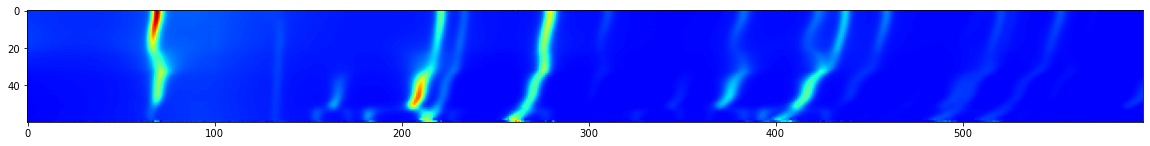

In [15]:
plt.imshow(sample(patterns, fast_T)[1], cmap = 'jet')

In [39]:
# TODO fast_q or slow_T - background?
data_samples = sample(fast_q * (fast_q > 0), fast_T, N = N)

In [40]:
%%capture 
X_samples = np.array([get_activations(sample).T for sample in data_samples]);

In [1192]:
with open('data/augmented.npy', 'wb') as f:
    np.save(f, X_samples)

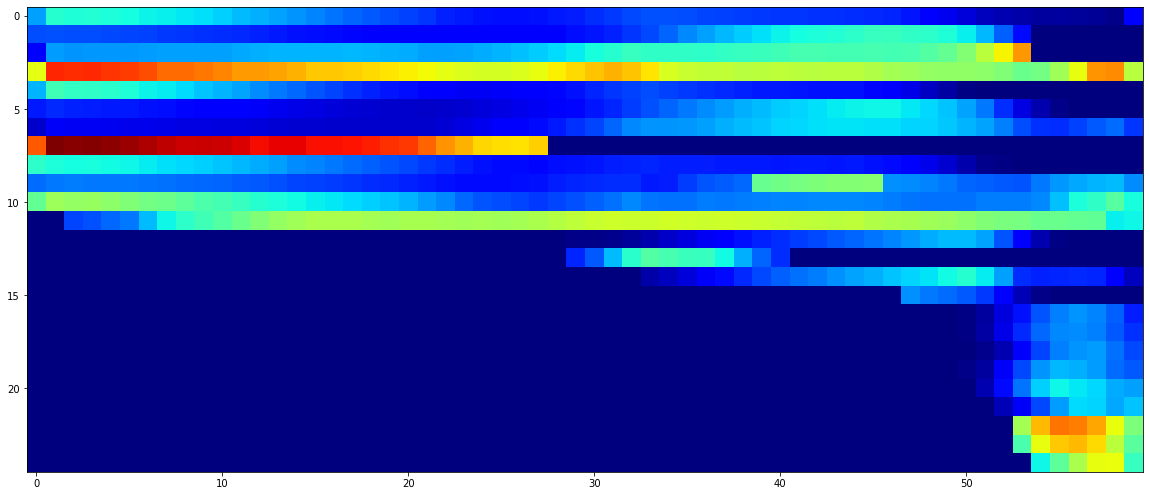

In [18]:
plt.imshow(X_samples[0].T, cmap = 'jet')

<ipython-input-78-cc98622538dd>:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(1 + fast_q), cmap = 'jet')


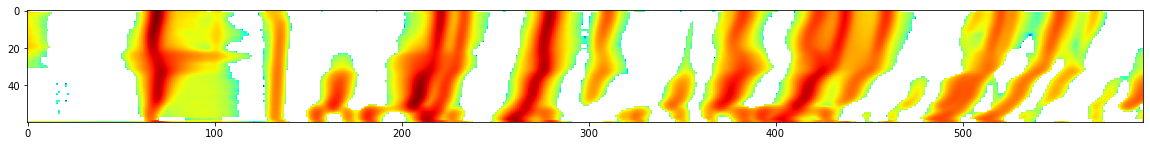

In [78]:
plt.imshow(np.log(1 + fast_q), cmap = 'jet')

<ipython-input-77-c8fb956aa827>:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(1 + samples[0]), cmap = 'jet')


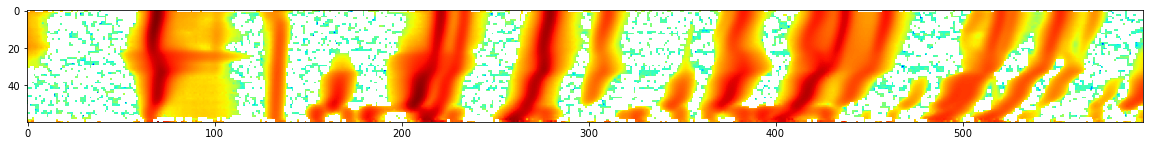

In [77]:
plt.imshow(np.log(1 + samples[0]), cmap = 'jet')

In [7]:
# patterns_pp = fast_q - fast_q.min()
# patterns_pp /= patterns_pp.mean()
# fitlists = fsub_stop_2d[1]

# labeled, feature_masks, activations, norm_, activations_n1 = feat.peakfit_featurize(patterns_pp, fitlists,
#                                                                     size_thresh = 5, peakwidth = 1.5)

In [19]:
from xrdc import misc

{'linkage': 'ward', 'affinity': 'euclidean'}


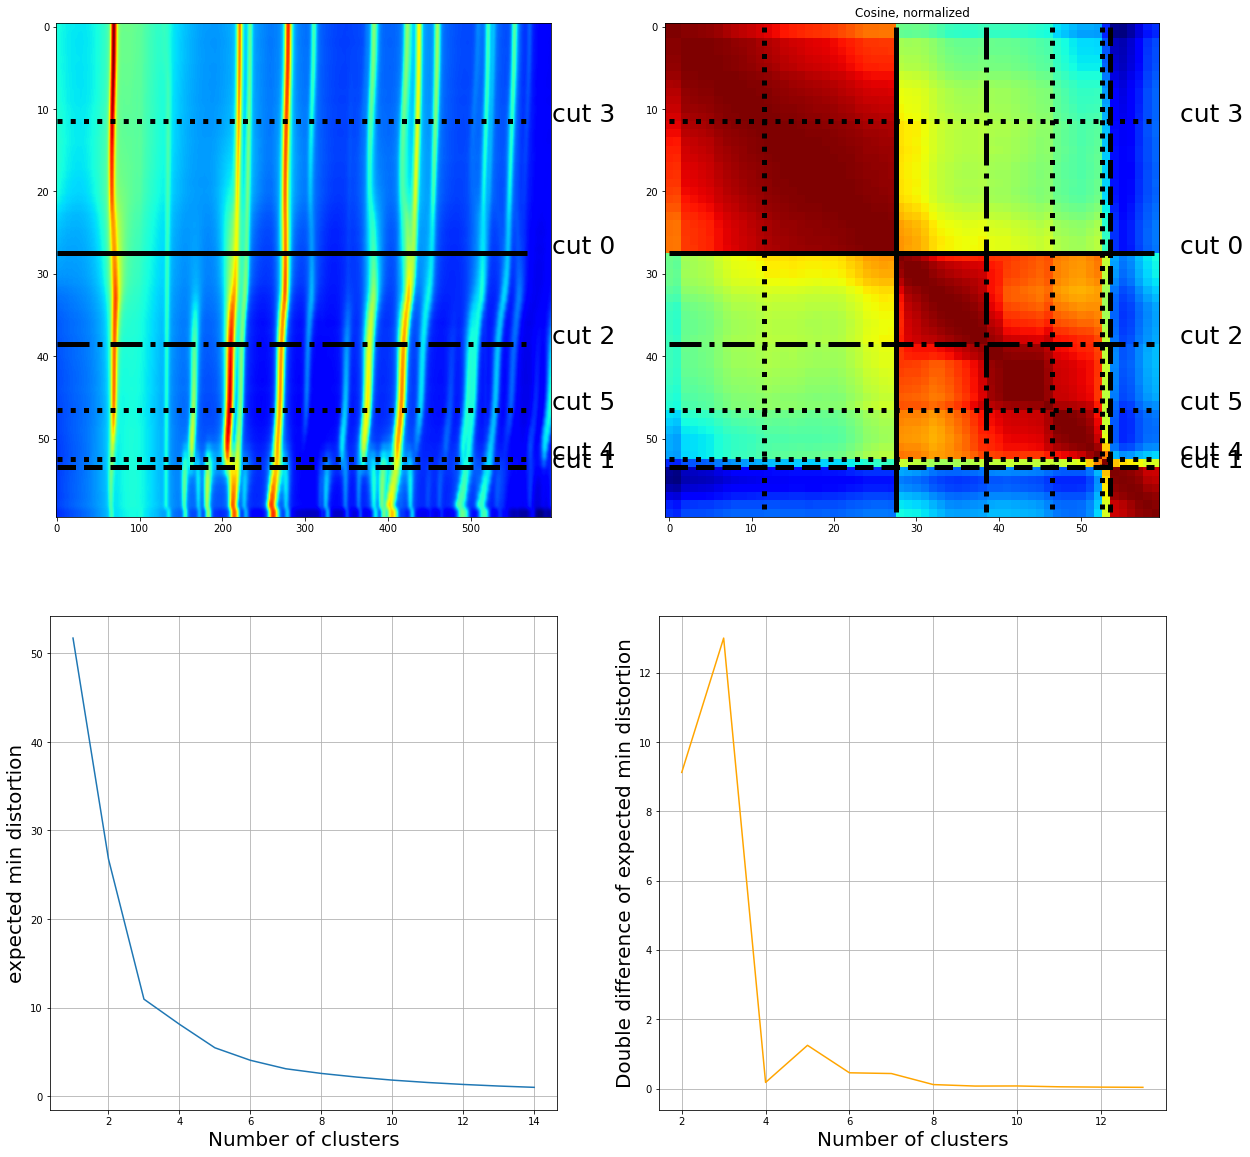

In [87]:
simtype = 'Cosine'
scaling = 'log'
linkage = 'ward'
ctype = 'agglom'

feature_csims1, o_cuts = feat.sims_with_boundaries(patterns, activations_n1_simple, activations_n1_simple, n = 7, simtype = simtype, extra_label='',
                    ctype = ctype, linkage = linkage, affinity = 'euclidean')

25.16454159500381
{'linkage': 'ward', 'affinity': 'euclidean'}


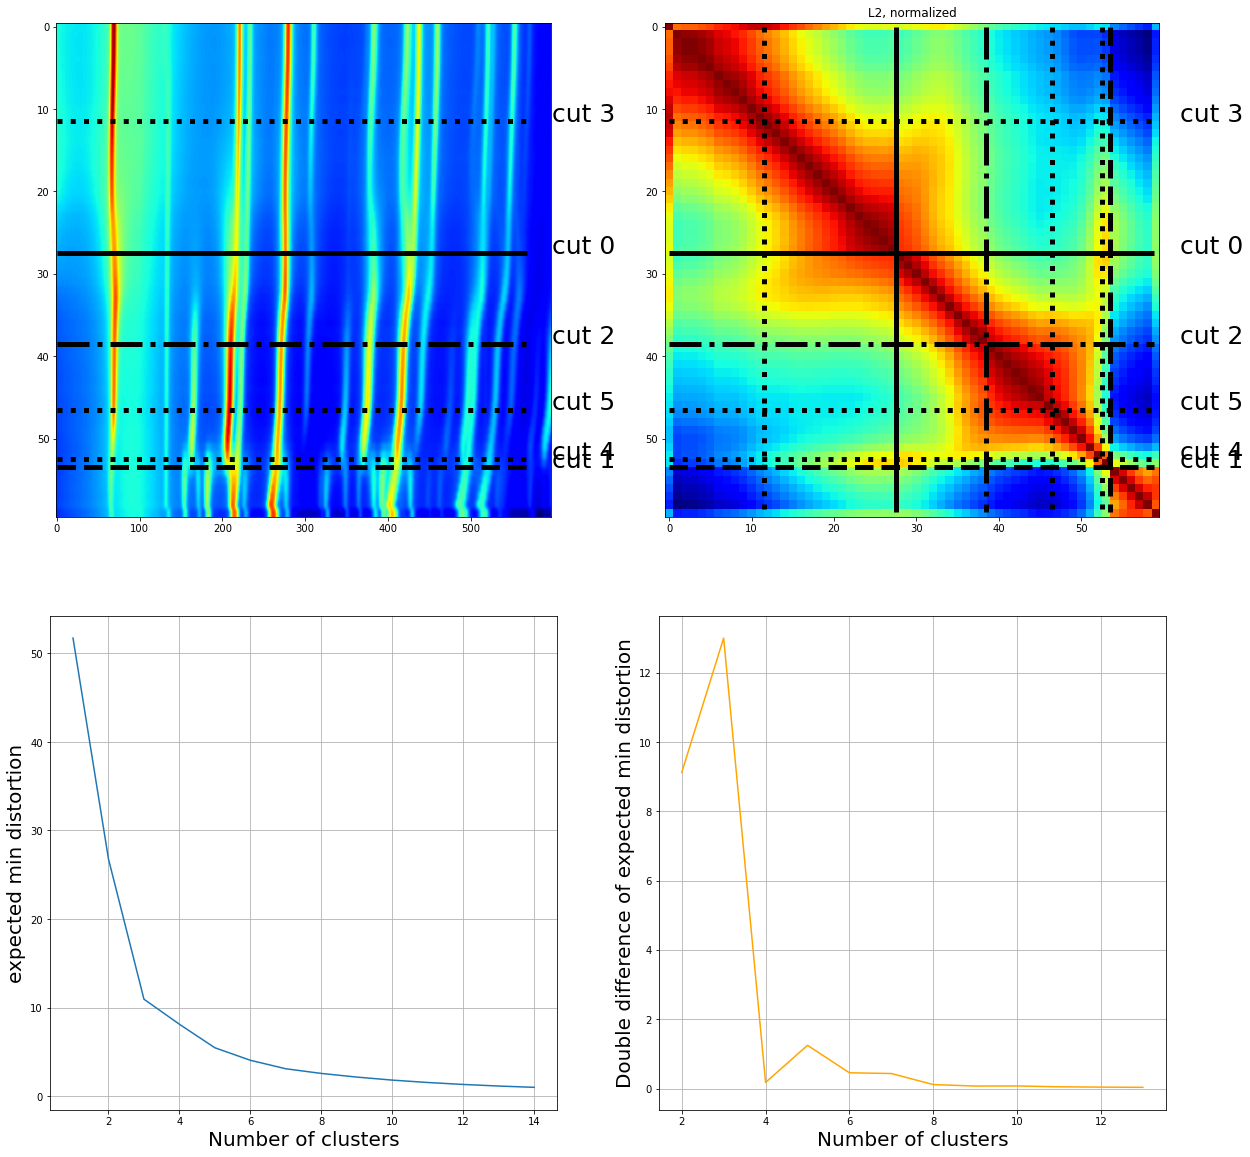

In [118]:
simtype = 'Cosine'
scaling = 'log'
linkage = 'ward'
ctype = 'agglom'

feature_csims1, o_cuts = feat.sims_with_boundaries(patterns, get_activations(fast_q * (fast_q > 0)),np.mean(X_samples, axis = 0).T, n = 7, simtype = simtype, extra_label='',
                    ctype = ctype, linkage = linkage, affinity = 'euclidean')

In [20]:
act = activations_n1_simple

X = act.T

In [21]:
def l2_pairs(a):
    """
    Calculate L2 distances.
    """
    #b = b.reshape((b.shape[0], 1, a.shape[1]))
    b = a.reshape((a.shape[0], 1, a.shape[1]))
    dist_l2 = np.sqrt(np.einsum("ijk, ijk->ij", a - b, a - b))
    return dist_l2

In [22]:
import pandas as pd

In [48]:
def boot_step(outputs, c_probs):
    # update probabilities
    idx_draws = [(o[-1],) for o in outputs]
    #idx_draws = [o[-1] for o in outputs]

    draw_counts = pd.DataFrame(idx_draws).value_counts().sort_values()

    imerge, jmerge = draw_counts.sort_values().index[-1][0]

    draw_probs = draw_counts / draw_counts.sum()

    #new_prob = draw_probs[(imerge, jmerge)].iloc[0] * np.prod(c_probs[[imerge, jmerge]])

    # use this output for the next agglo clustering iteration 
    for i, (_, _, _, _, idx_pair) in enumerate(outputs):
        if idx_pair == (imerge, jmerge):
            imatch = i
            break
    #distances_tmp, ids_tmp, clusters_tmp, c_sizes_tmp = outputs[imatch]
    
    idx_other = np.array(list(set(list(range(len(c_probs)))) - set([imerge, jmerge])))
#     # TODO
#     # pd.DataFrame(draw_probs.iloc[:-1], columns = ['prob']).reset_index()
#     other_probs = c_probs[idx_other]
#     c_probs_tmp = np.hstack((new_prob, other_probs))

    outputs_tmp = [agglom_step(*output) for output in outputs]
    return outputs_tmp, c_probs#c_probs_tmp

def get_new_distance(new_size, imerge, jmerge, k, c_sizes, distances):
    N = (new_size + c_sizes[k])
    ai = ((c_sizes[imerge] + c_sizes[k]) / N)
    aj = ((c_sizes[jmerge] + c_sizes[k]) / N)
    b = ((c_sizes[k]) / N)
    return ai * distances[imerge, k] + aj * distances[jmerge, k] - b * distances[imerge, jmerge]

def agglom_step(distances, ids, clusters, c_sizes, *args):
    imerge, jmerge = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    newcluster = np.vstack((clusters[imerge], clusters[jmerge]))
    
    newcluster_ids = np.concatenate(ids[[imerge, jmerge]])[None, :]

    idx_other = np.array(list(set(list(range(len(clusters)))) - set([imerge, jmerge])))

    otherclusters = [clusters[idx] for idx in idx_other]

    otherclusters_ids = ids[idx_other]

    new_size = c_sizes[[imerge, jmerge]].sum()
    others_sizes = c_sizes[idx_other]

    # calculate new pairwise distance matrix
    #new_distances_ij = np.array([get_new_distance(new_size, imerge, jmerge, , c_sizes) for k in idx_other])
    new_distances_ij = get_new_distance(new_size, imerge, jmerge, idx_other, c_sizes, distances)
    distances_tmp = distances[np.ix_(idx_other.ravel(), idx_other.ravel())]
    distances_tmp = np.hstack((
          np.vstack(([np.inf], new_distances_ij[:, None])),
          np.vstack((new_distances_ij, distances_tmp))))

    clusters_tmp = np.array([newcluster] + otherclusters, dtype = object)

    ids_tmp = np.array(list(newcluster_ids) + list(otherclusters_ids), dtype = object)

    c_sizes_tmp = np.hstack((new_size, c_sizes[idx_other]))
    
    
    return distances_tmp, ids_tmp, clusters_tmp, c_sizes_tmp, (imerge, jmerge)

# initialization
def get_init(X):
    ids = np.arange(len(X))[:, None]

    clusters = np.empty(shape = len(X), dtype = object)
    clusters.fill(X[:, None])
    #clusters = list(X[:, None])
    distances = feat.l2_pairs(X)
    c_sizes = np.ones(len(clusters))#np.array(misc.deepmap(clusters, lambda clust: len(clust), level = 1))
    np.fill_diagonal(distances, np.inf)
    return distances, ids, clusters, c_sizes


# initialization
#distances, ids, clusters, c_sizes
outputs = [agglom_step(*get_init(X)) for X in X_samples]
_, _, _, sizes_tmp, _ = outputs[0]
c_probs = np.ones_like(sizes_tmp)

In [655]:
outputs[10][1]

array([array([49, 50, 51, 47, 48, 52, 53, 43, 44, 45, 41, 42, 46, 39, 40, 37, 38,
              35, 36, 33, 34, 32, 29, 30, 31, 28, 54, 55, 56, 57, 58, 59])       ,
       array([17, 18, 19, 20, 21, 22, 15, 16, 14, 12, 13, 24, 25, 26, 27, 23,  4,
               5,  2,  3,  1,  0, 10, 11,  8,  9,  6,  7])                       ],
      dtype=object)

In [49]:
def get_final_clusters(outputs):
    final_clusters = np.vstack([o[1] for o in outputs])
    # sort clusters by mean index
    final_clusters = np.array([rows[np.argsort([r.mean() for r in rows])] for rows in final_clusters])
    return final_clusters

In [50]:
nclust = len(patterns)

final_clust_dict = dict()

for _ in range(len(patterns) - 3):
    outputs, c_probs = boot_step(outputs, c_probs);
    nclust -= 1
    final_clust_dict[nclust] = get_final_clusters(outputs)

In [662]:
nclusters = 4

In [667]:
clustering = AgglomerativeClustering(n_clusters=4).fit_predict(X_samples[0])

177 µs ± 276 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [664]:
cluster_indices = []
for i in range(nclusters):
    cluster_indices.append(np.arange(len(patterns))[clustering == i])

In [1189]:
len(outputs)

1000

In [1191]:
outputs[-3][1]

array([array([49, 50, 51, 47, 48, 52, 53, 43, 44, 45, 41, 42, 46, 39, 40, 33, 34,
              35, 36, 31, 32, 37, 38, 29, 30, 28, 54, 55, 56, 57, 58, 59])       ,
       array([ 8,  9, 10,  6,  7, 11, 12, 13, 14,  4,  5,  2,  3,  1,  0, 17, 18,
              15, 16, 19, 20, 21, 26, 27, 24, 25, 22, 23])                       ],
      dtype=object)

In [665]:
cluster_indices

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]),
 array([54, 55, 56, 57, 58, 59]),
 array([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38])]

In [51]:
N

1000

In [770]:
def print_cluster_stats(i):
    sets_i = list(map(set, final_clusters[:, i]))
    setsims = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            setsims[i, j] += int(sets_i[i] == sets_i[j])

    ss = setsims.sum(axis = 0)

    highest_prob = np.argsort(ss)[-1]

    print('cluster:', sets_i[highest_prob])
    print('with probability:', ss.max(), 'percent')
    
def boundary_freq(i, final_clusters):
    sets_i = np.array(list(map(lambda x: np.array((np.max(x), np.min(x))), final_clusters[:, i])))
    return sets_i[:, 0], sets_i[:, 1]

In [54]:
# bound_values = boundary_freq(0)[0]

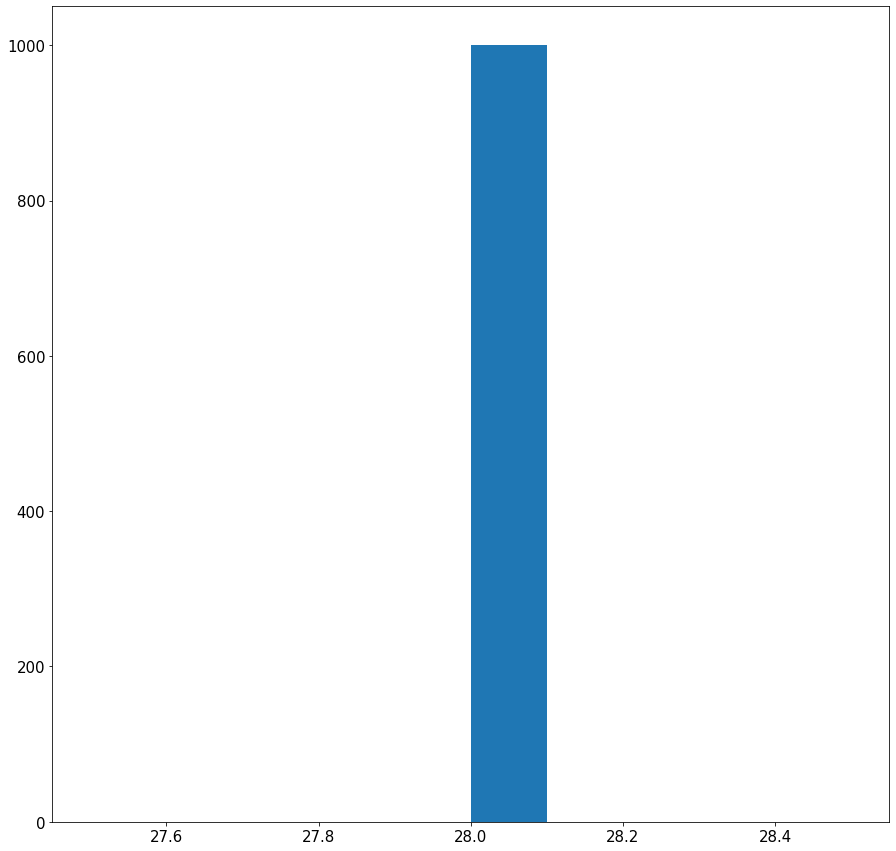

In [1047]:
plt.hist(boundary_freq(1, final_clusters)[1]);

In [ ]:
X

In [1109]:
import pdb
def get_cut_groups(i, final_clusters, threshold = 0.0, tol = 1):
    """
    Get cluster boundary indices and probabilities, with the specified
    tolerance for grouping together nearby boundaries.
    """
    bound_values = boundary_freq(i, final_clusters)[0]
    bound_counts = pd.DataFrame([bound_values]).T.value_counts().astype(int)
    bound_freqs = bound_counts / bound_counts.sum()
    bound_freqs = bound_freqs.sort_values(ascending = False)

    bound_freqs = bound_freqs[bound_freqs > threshold]
    bf_df = pd.DataFrame(bound_freqs, columns = ['freq']).reset_index()

    heads = dict()
    group_indices = dict()

    head = bf_df[0][0]
    head_prob = bf_df['freq'].iloc[0]
    heads[head] = head_prob
    current_indices = (bound_values == head)

    for row, nextrow in zip(list(bf_df.iterrows()), list(bf_df.iterrows())[1:]):
        i = int(row[1][0])
        j = int(nextrow[1][0])
        if np.abs(i - j) <= tol:
            head_prob += round(nextrow[1]['freq'], 2)
            current_indices = (current_indices | (bound_values == j))
        else:
            heads[head] = head_prob
            group_indices[head] = current_indices

            current_indices = (bound_values == j)
            head_prob = nextrow[1]['freq']
            head = j

    heads[head] = head_prob
    group_indices[head] = current_indices
    return heads, group_indices

In [706]:
def iter_combos(lsts, getter):
    if len(lsts) == 0:
        yield []
    else:
        for k, v in lsts[0].items():
            for rest in iter_combos(lsts[1:], getter):
                yield [getter(k, v)] + rest

In [1104]:
def compile_ensemble(nclust, rank = 0, tol = 1):
    final_clusters = final_clust_dict[nclust + 1]

    cuts = [get_cut_groups(i, final_clusters, tol = tol) for i in range(nclust)]
    cuts_idxs = list(zip(*cuts))[0]
    cuts_masks = list(zip(*cuts))[1]

    itmasks = list(iter_combos(cuts_masks, lambda k, v: v))
    configuration_masks = np.array([reduce(lambda a, b: a & b, itmask) for itmask in itmasks])
    configuration_counts = np.array([reduce(lambda a, b: a & b, itmask).sum() for itmask in itmasks])
    configuration_freqs = configuration_counts / configuration_counts.sum()
    
    
    #mask_most_probable_configuration = configuration_masks[np.argmax(configuration_counts)]
    config_mask = configuration_masks[np.argsort(configuration_counts)[::-1][rank]]

    summary = pd.DataFrame([list(iter_combos(cuts_idxs, lambda k, v: k)),
                list(iter_combos(cuts_idxs, lambda k, v: v)),
                configuration_freqs]).T
    summary.columns = ['cut coords', 'cut probs (unconditional)', 'configuration prob']
    summary = summary.reset_index().sort_values('configuration prob', ascending = False)

    return cuts_idxs, config_mask, summary, final_clusters

def annotated_dendrogram(Z, nclusters, labels, cut_coords, reverse_order = False,
                        ax = None):
    def sorter(node):
        if reverse_order:
            return -sort_icoord(node)
        else:
            return sort_icoord(node)
    
    dendro = dendrogram(Z, ax=ax, color_threshold=0, leaf_font_size = 15)
    #plt.ylim(dn_clusters_to_dcoord(dendro, nclusters + 1), 10)

    nodes = filter_dn(dendro, lambda node: node['color_list'] == 'C0')
    nodes = slice_dn(sort_dn(nodes, sort_dcoord), nclusters)
    nodes = sort_dn(nodes, sorter)
    
    for ind, right in enumerate(cut_coords[:-1]):
        ax.annotate(labels[ind], ((right), 25), xytext = (0, -5),
                    textcoords = 'offset points', va = 'top', ha = 'center',
                   size = 20)
    return dendro

sort_icoord = lambda node: (0.5 * sum(node['icoord'][1:3]))
sort_dcoord = lambda node: node['dcoord'][1]

def show_ensemble_dendrogram(nclust, ax = None, rank = 0, tol = 1):
    cuts_idxs, config_mask, summary, final_clusters =\
        compile_ensemble(nclust, rank = rank, tol = tol)

    selected_idx = np.where(config_mask)[0][0]
    print(selected_idx)

    #selected_X = X_samples[np.where(config_mask)[0]].mean(axis = 0)#
    selected_X = X_samples[selected_idx]

    Z = linkage(selected_X, method = 'ward', optimal_ordering = True)

    # unconditional cluster probs
    cluster_probs = summary.iloc[rank].iloc[2]
    config_prob = summary.iloc[rank, -1]
    labels = list(map(lambda num: "p = {}".format(num), cluster_probs))

    cut_coords = (np.array(list(iter_combos(cuts_idxs, lambda k, v: k)))[summary.index[rank]])
    dn = annotated_dendrogram(Z, nclust, labels, 10 * (cut_coords + 1), ax = ax)

    ax.vlines(10 * (cut_coords + 1)[:-1], 0, 50, colors='k', linestyles='dashed', linewidth = 3)
    ax.set_title("N = {}. Cluster configuration probability: {}".format(nclust, config_prob))
    
    return summary, Z, dn, final_clusters, selected_X, cut_coords[:-1]

In [1193]:
pwd

'/home/ollie/Documents/scratch/xrd_clustering/notebooks'

8


,index,cut coords,cut probs (unconditional),configuration prob
1,1,"[5, 13, 21, 27, 32, 38, 46, 52, 53, 59]","[0.853, 0.757, 0.988, 1.0, 0.631, 1.0, 1.002, ...",0.389
0,0,"[5, 13, 21, 27, 30, 38, 46, 52, 53, 59]","[0.853, 0.757, 0.988, 1.0, 0.365, 1.0, 1.002, ...",0.226
9,9,"[5, 11, 21, 27, 32, 38, 46, 52, 53, 59]","[0.853, 0.24200000000000002, 0.988, 1.0, 0.631...",0.146
41,41,"[7, 13, 21, 27, 32, 38, 46, 52, 53, 59]","[0.139, 0.757, 0.988, 1.0, 0.631, 1.0, 1.002, ...",0.081
8,8,"[5, 11, 21, 27, 30, 38, 46, 52, 53, 59]","[0.853, 0.24200000000000002, 0.988, 1.0, 0.365...",0.076


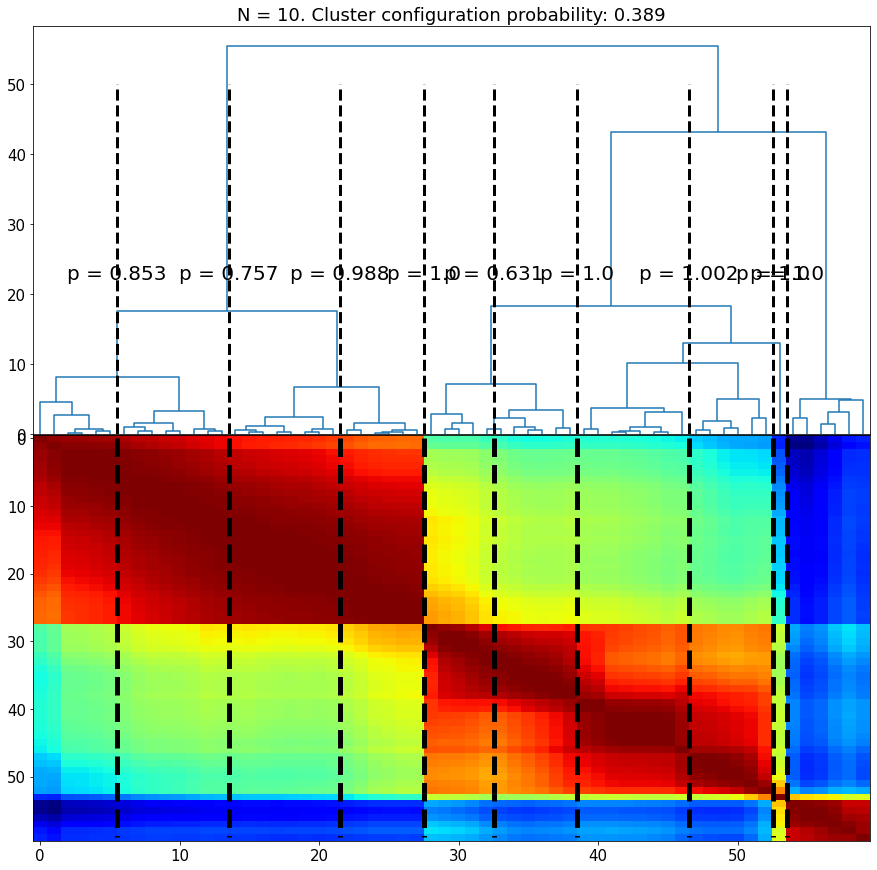

In [1198]:
nclust = 10
# cuts_idxs, mask_most_probable_configuration, summary, final_clusters = compile_ensemble(nclust)
# summary
fig = plt.figure()
summary, Z, dn, final_clusters, selected_X, cut_coords =\
    show_ensemble_dendrogram(nclust, ax = plt.subplot(211),
                            tol = 1)
ax2 = plt.subplot(212)
ax2.imshow(feat.csim_pairs(selected_X), cmap = 'jet', aspect = .485)
ax2.vlines(cut_coords + .5, 0, 59, colors='k', linestyles='dashed', linewidth = 5)
plt.subplots_adjust(hspace=0)
fig.savefig('images/{}.png'.format(10 - nclust))
summary.iloc[:5]

0


,index,cut coords,cut probs (unconditional),configuration prob
0,0,"[27, 53, 59]","[1.0, 1.005, 1.0]",1.0


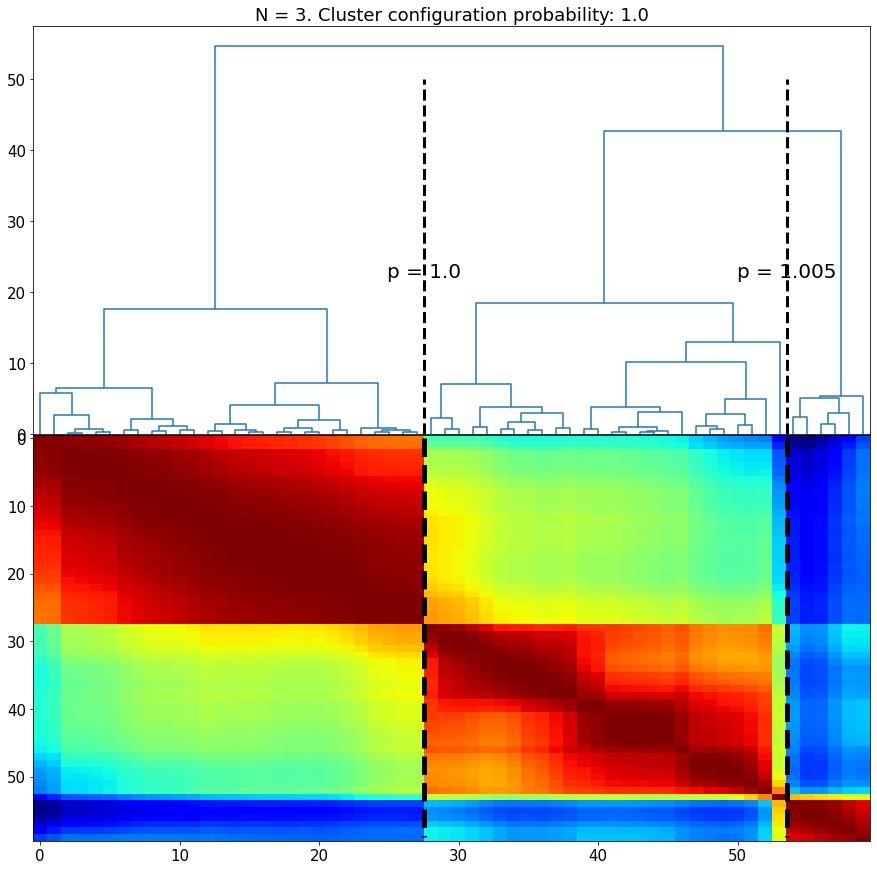

In [1197]:
nclust = 3
# cuts_idxs, mask_most_probable_configuration, summary, final_clusters = compile_ensemble(nclust)
# summary
fig = plt.figure()
summary, Z, dn, final_clusters, selected_X, cut_coords =\
    show_ensemble_dendrogram(nclust, ax = plt.subplot(211),
                            tol = 1)
ax2 = plt.subplot(212)
ax2.imshow(feat.csim_pairs(selected_X), cmap = 'jet', aspect = .485)
ax2.vlines(cut_coords + .5, 0, 59, colors='k', linestyles='dashed', linewidth = 5)
plt.subplots_adjust(hspace=0)
fig.savefig('images/{}.png'.format(10 - nclust))
summary.iloc[:5]

5


,index,cut coords,cut probs (unconditional),configuration prob
1,1,"[27, 38, 53, 59]","[0.423, 0.423, 1.005, 1.0]",0.423
2,2,"[13, 27, 53, 59]","[0.308, 0.577, 1.005, 1.0]",0.308
4,4,"[11, 27, 53, 59]","[0.196, 0.577, 1.005, 1.0]",0.196
6,6,"[14, 27, 53, 59]","[0.045, 0.577, 1.005, 1.0]",0.045
8,8,"[10, 27, 53, 59]","[0.026, 0.577, 1.005, 1.0]",0.027


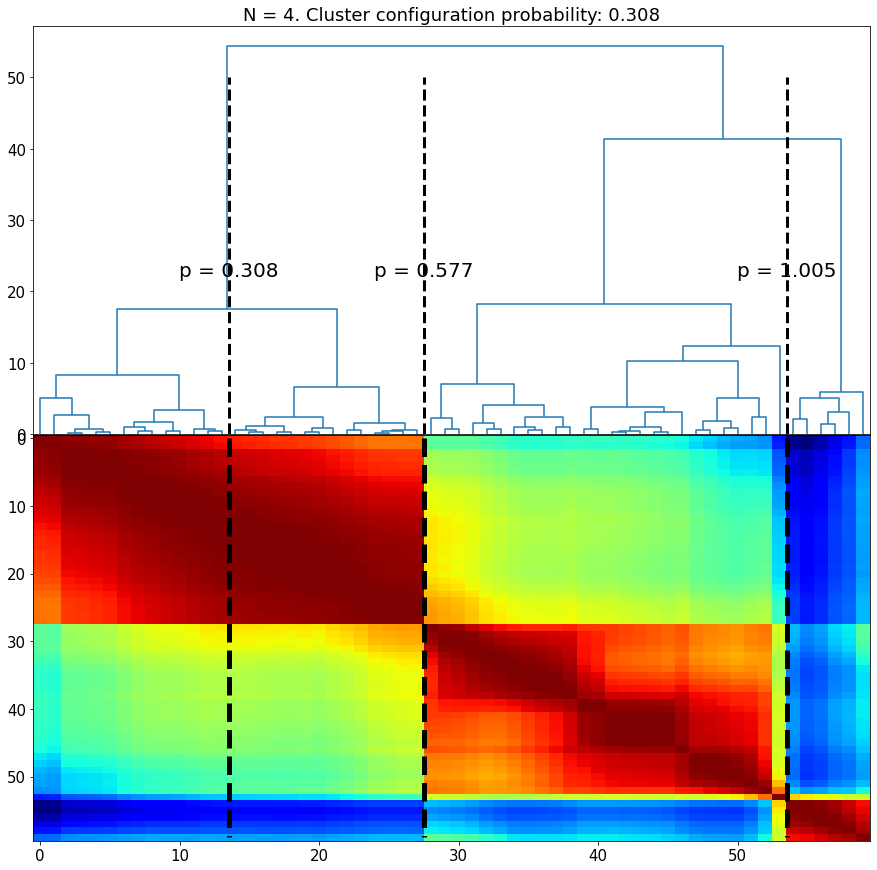

In [1116]:
nclust = 4
# cuts_idxs, mask_most_probable_configuration, summary, final_clusters = compile_ensemble(nclust)
# summary
                             
summary, Z, dn, final_clusters, selected_X, cut_coords =\
    show_ensemble_dendrogram(nclust, ax = plt.subplot(211),
                            rank = 1)
ax2 = plt.subplot(212)
ax2.imshow(feat.csim_pairs(selected_X), cmap = 'jet', aspect = .485)
ax2.vlines(cut_coords + .5, 0, 59, colors='k', linestyles='dashed', linewidth = 5)
plt.subplots_adjust(hspace=0)

summary.iloc[:5]

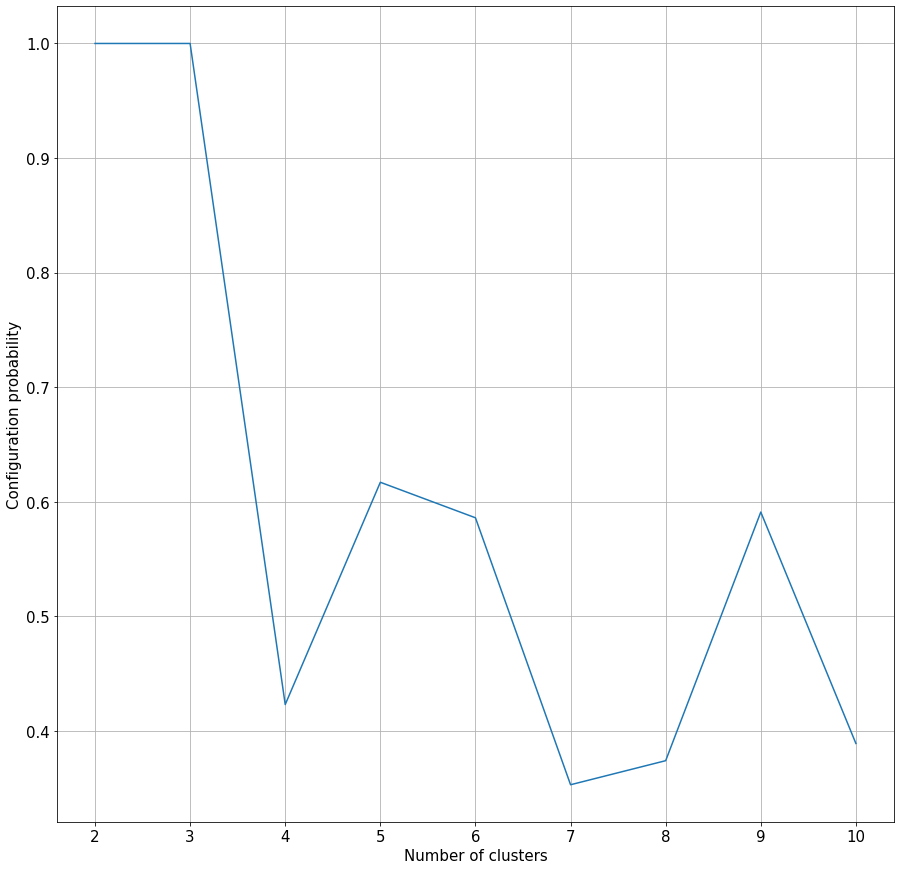

In [1045]:
nclust_grid = np.arange(2, 11).astype(int)
summary_progression = [compile_ensemble(nclust)[2].iloc[0].iloc[-1]
                       for nclust in nclust_grid]
plt.plot(nclust_grid, summary_progression)
plt.xlabel('Number of clusters')
plt.ylabel('Configuration probability')
plt.grid()

In [1144]:
from xrdc import visualization as vis

In [1151]:
vis.do_pca(selected_X, 2)

(PCA(n_components=2),
 array([[-6.29884631,  1.72212049],
        [-7.69954619,  1.74735173],
        [-7.35292056,  1.50595048],
        [-7.37329957,  1.50221449],
        [-7.22753951,  1.45191234],
        [-7.09493923,  1.4065023 ],
        [-6.79625993,  1.26962841],
        [-6.52335486,  1.14339222],
        [-6.33481822,  1.07909179],
        [-6.25029006,  1.06282044],
        [-6.09084426,  1.02132593],
        [-5.86864155,  0.94856501],
        [-5.58518955,  0.86433741],
        [-5.55880624,  0.87555957],
        [-5.38944988,  0.84672313],
        [-5.20556829,  0.82990746],
        [-5.10854764,  0.83688678],
        [-5.04348107,  0.85779348],
        [-4.87562194,  0.8488015 ],
        [-4.60812852,  0.81990613],
        [-4.43813347,  0.79662909],
        [-4.18334385,  0.7598802 ],
        [-3.55696804,  0.57935263],
        [-3.10840788,  0.41776833],
        [-2.75033132,  0.24849909],
        [-2.65299606,  0.15707277],
        [-2.59737651,  0.07336815],
      

In [1165]:
selected_X.shape

(60, 25)

In [1166]:
patterns.shape

(60, 597)

Text(0.5, 1.0, '2D PCA projection')

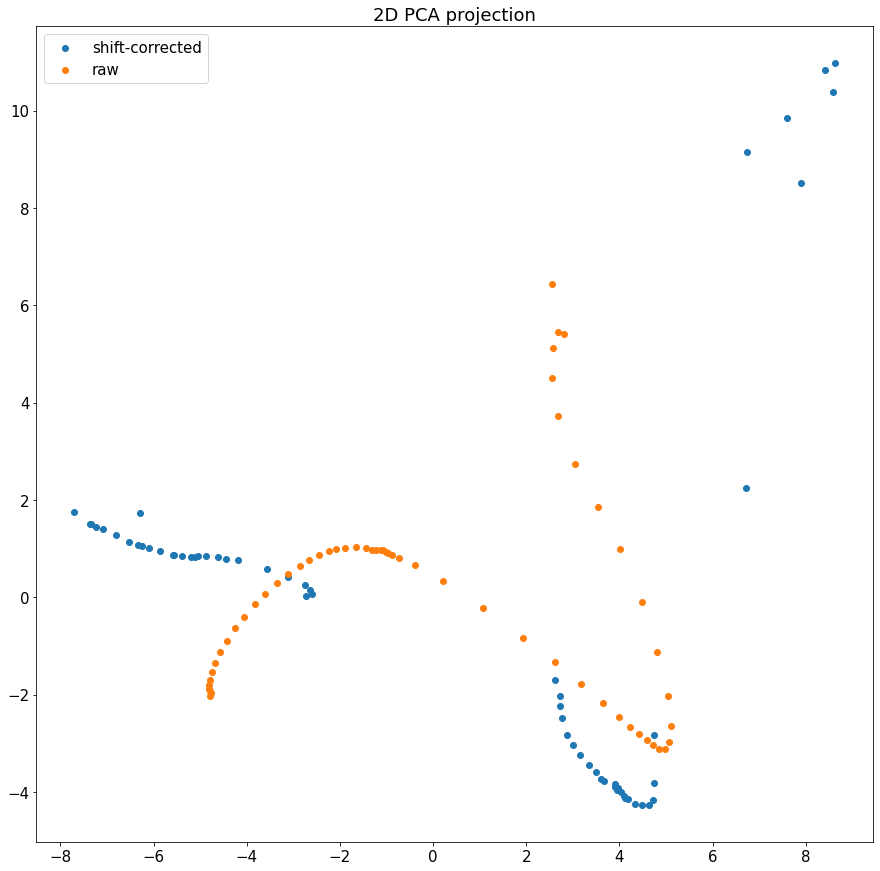

In [1170]:
plt.scatter(*(vis.do_pca(selected_X, 2)[1].T), label = 'shift-corrected')
plt.scatter(*(vis.do_pca(patterns / 10000, 2)[1].T), label = 'raw')
plt.legend()
plt.title("2D PCA projection")

In [1158]:
vis.do_pca(selected_X, 2)[1].T[0]

array([-6.29884631, -7.69954619, -7.35292056, -7.37329957, -7.22753951,
       -7.09493923, -6.79625993, -6.52335486, -6.33481822, -6.25029006,
       -6.09084426, -5.86864155, -5.58518955, -5.55880624, -5.38944988,
       -5.20556829, -5.10854764, -5.04348107, -4.87562194, -4.60812852,
       -4.43813347, -4.18334385, -3.55696804, -3.10840788, -2.75033132,
       -2.65299606, -2.59737651, -2.73159946,  2.61770508,  2.72707969,
        2.73321042,  2.76368855,  2.87931865,  3.00746805,  3.16154482,
        3.33535975,  3.48544429,  3.5960936 ,  3.66371334,  3.8984045 ,
        3.95175425,  3.90111926,  3.96968932,  4.042909  ,  4.09657251,
        4.17787879,  4.11341419,  4.33432806,  4.48714029,  4.62393825,
        4.71509673,  4.74658067,  4.73226697,  6.70557455,  7.88820845,
        8.58343278,  8.63108864,  8.41110213,  7.5919809 ,  6.7321435 ])

In [843]:
tc = cut_tree(Z, n_clusters=nclust).ravel()
node = to_tree(Z)

In [461]:
def _ncluster_to_level(nodelist, ncluster):
    if ncluster <= 0 or len(nodelist) == 0:
        return 0
    remaining = ncluster - len(nodelist)
    new_nodelist = []
    for node in nodelist:
        if node is not None:
            new_nodelist.append(node.left)
            new_nodelist.append(node.right)
    return 1 + _ncluster_to_level(new_nodelist, remaining)

def ncluster_to_level(Z, ncluster):
    node = to_tree(Z)
    return _ncluster_to_level([node], ncluster)

def _depth(node):
    if node is None:
        return 0
    return 1 + max(_depth(node.left), _depth(node.right))

def depth(Z):
    node = to_tree(Z)
    return _depth(node)

def dn_clusters_to_dcoord(dn, ncluster):
    dcoord = dn['dcoord']
    return np.min(np.array(dcoord[-ncluster:])[:, 1])

def dn_clusters_to_icoord(dn, ncluster):
    icoord = np.array(dn['icoord'][-ncluster:])
    bnds = np.unique(icoord[:, 1:3].ravel())
    return bnds[np.argsort(bnds)].reshape(-1, 2)

def dn_take(dn, i):
    res = dict()
    for k, v in dn.items():
        res[k] = v[i]
    return res

# Tests
# res = filter_height(dn, 3)

# dn_take(dn, 5)

# dn_take(dn, 5)

# res = dn_put(None, dn_take(dn, 5))

# res = dn_put(res, dn_take(dn, 4))
# res

def dn_put(dn, node):
    dn = deepcopy(dn)
    if dn is None:
        dn = dict()
        for k, v in node.items():
            dn[k] = [v]
    else:
        for k, v in dn.items():
            dn[k] = dn[k] + [node[k]]
    return dn


def filter_height(dn, thresh):
    """
    Return dendrogram nodes at the height range corresponding to the given number of clusters
    """
    res = None
    for i, dcs in enumerate(dn['dcoord']):
        dc = dcs[1]
        if dc >= thresh:
            res = dn_put(res, dn_take(dn, i))
    return res


def filter_dn(dn, fn):
    res = dict()
    for k in dn.keys():
        res[k] = []
    for i in range(len(dn[k])):
        if fn(dn_take(dn, i)):
            res = dn_put(res, dn_take(dn, i))
    return res

def sort_dn(dn, fn):
    res = dict()
    nnodes = len(dn['dcoord'])
    idx_sort = np.argsort([fn(node) for node in 
                          map(dn_take, [dn] * nnodes, range(nnodes))])
    for k in dn.keys():
        res[k] = np.array(dn[k], dtype = object)[idx_sort].tolist()
        #res[k] = [list(elt) for elt in res[k]]
        #print(res[k])
    return res

def slice_dn(dn, i):
    res = dict()
    for k, v in dn.items():
        res[k] = v[:i]
    return res

In [675]:
Z = linkage(selected_X)
Z = linkage(X_samples[5])
Z = linkage(X_samples[np.where(mask_most_probable_configuration)[0]].mean(axis = 0), method = 'ward')

# i = 3
# selected_X = X_samples[np.where(mask_most_probable_configuration)[0][i]]
# Z = linkage(selected_X, method='ward')

In [678]:
from scipy.cluster.hierarchy import fcluster

Text(0.5, 1.0, 'Cluster configuration probability: 0.423')

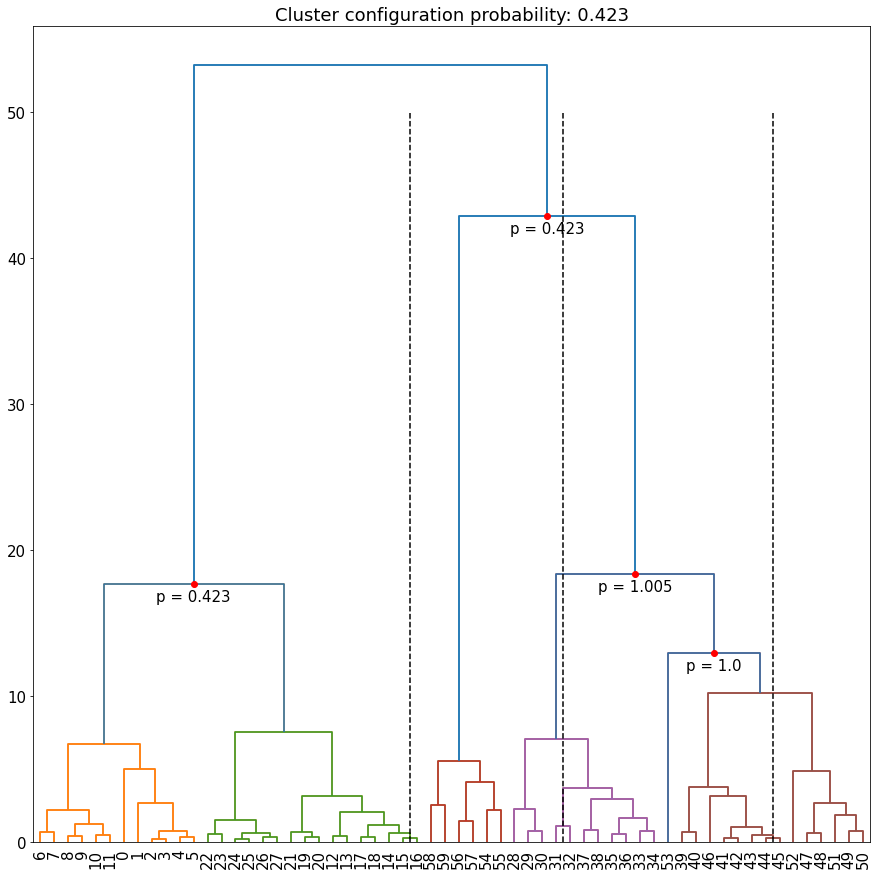

In [705]:
Z = linkage(X_samples[np.where(mask_most_probable_configuration)[0]].mean(axis = 0), method = 'ward')


plt.rc('font', size=15) 
plt.rc('xtick', labelsize=15) #fontsize of the x tick labels

# unconditional cluster probs
cluster_probs = summary.loc[selected_idx].iloc[1]
labels = list(map(lambda num: "p = {}".format(num), cluster_probs))

cut_coords = 10 * np.array(list(iter_combos(cuts_idxs, lambda k, v: k)))[selected_idx][:-1]
annotated_dendrogram(Z, 4, labels)

plt.vlines(cut_coords, 0, 50, colors='k', linestyles='dashed')

plt.title("Cluster configuration probability: {}".format(configuration_freqs[selected_idx]))

In [471]:
dn_take(dn, 5)

{'icoord': [115.0, 115.0, 125.0, 125.0],
 'dcoord': [0.0, 0.6171571655944829, 0.6171571655944829, 0.0],
 'ivl': 'foo',
 'leaves': 57,
 'color_list': 'C2'}

In [112]:
list(iter_combos(cuts_idxs, lambda k, v: v))

[[0.423, 0.577, 1.005, 1.0],
 [0.423, 0.423, 1.005, 1.0],
 [0.308, 0.577, 1.005, 1.0],
 [0.308, 0.423, 1.005, 1.0],
 [0.196, 0.577, 1.005, 1.0],
 [0.196, 0.423, 1.005, 1.0],
 [0.045, 0.577, 1.005, 1.0],
 [0.045, 0.423, 1.005, 1.0],
 [0.026, 0.577, 1.005, 1.0],
 [0.026, 0.423, 1.005, 1.0],
 [0.001, 0.577, 1.005, 1.0],
 [0.001, 0.423, 1.005, 1.0]]

In [994]:
# should sum to number of runs
sum([reduce(lambda a, b: a & b, itmask).sum() for itmask in itmasks])

2000

In [620]:
x, y = list(map(lambda x: np.hstack(x), list(zip(*[boundary_freq(i) for i in range(nclust)]))))
#x, y = np.hstack((x, y)), np.hstack((y, x))

In [621]:
vc = pd.DataFrame([x, y]).T.value_counts()

In [622]:
x, y = np.array(list(vc.index)).T
z = vc.values

In [623]:
y.mean(), x.mean()

(17.2, 31.2)

In [624]:
x.shape

(20,)

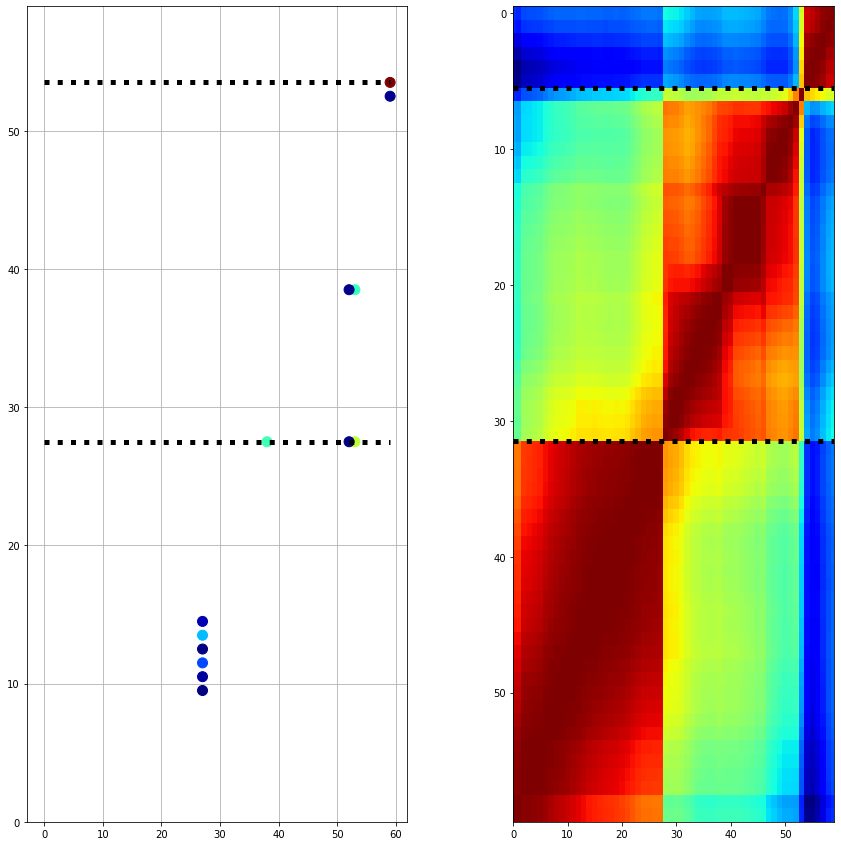

In [625]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]
a, b = 1, 2
plt.subplot(a, b, 1)
plt.scatter(x, y - .5, c = z / 2000, cmap = 'jet', s = 100)
plt.grid()
plt.ylim(0, 59)
plt.hlines(60 - 6.5, [0], [59], 'k', linewidth=5, linestyle = 'dotted')
plt.hlines(27.5, [0], [59], 'k', linewidth=5, linestyle = 'dotted')
#plt.colorbar()

plt.subplot(a, b, 2)
plt.imshow(feat.csim_pairs(act.T)[::-1, :], cmap = 'jet', aspect = 2.5)
plt.xlim(0, 59)
plt.hlines(5.5, [0], [59], 'k', linewidth=5, linestyle = 'dotted')
plt.hlines(60 - 28.5, [0], [59], 'k', linewidth=5, linestyle = 'dotted')


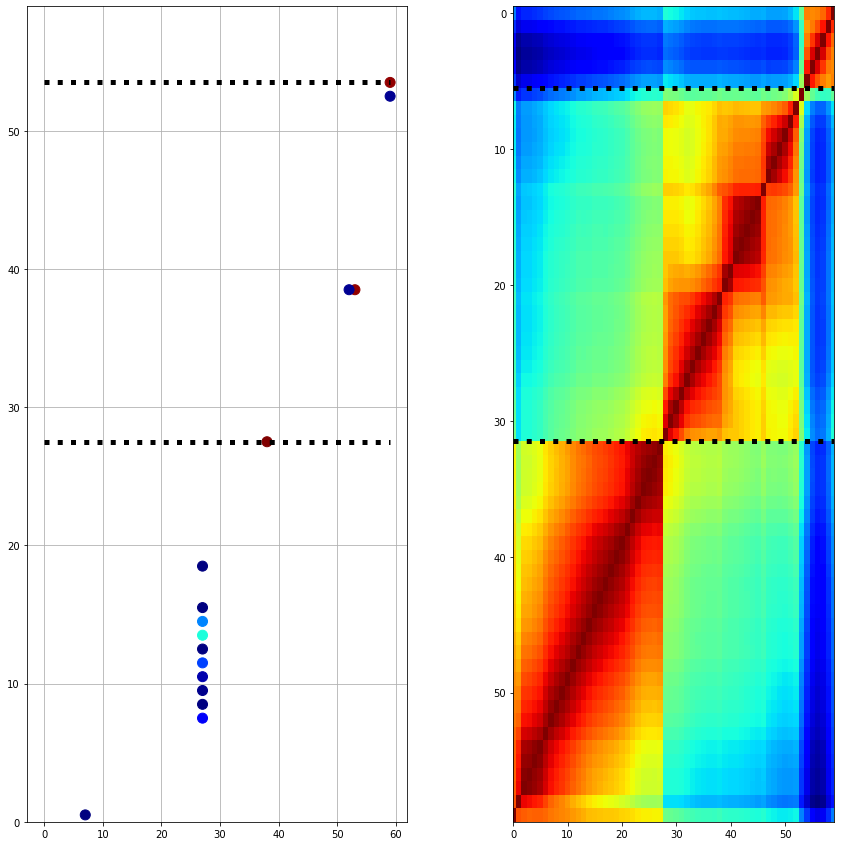

In [605]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]
a, b = 1, 2
plt.subplot(a, b, 1)
plt.scatter(x, y - .5, c = z / 2000, cmap = 'jet', s = 100)
plt.grid()
plt.ylim(0, 59)
plt.hlines(60 - 6.5, [0], [59], 'k', linewidth=5, linestyle = 'dotted')
plt.hlines(27.5, [0], [59], 'k', linewidth=5, linestyle = 'dotted')

#plt.colorbar()

plt.subplot(a, b, 2)
plt.imshow(feat.l2_sim(act.T)[::-1, :], cmap = 'jet', aspect = 2.5)
plt.xlim(0, 59)
plt.hlines(5.5, [0], [59], 'k', linewidth=5, linestyle = 'dotted')
plt.hlines(60 - 28.5, [0], [59], 'k', linewidth=5, linestyle = 'dotted')


In [459]:
x, y = np.hstack((x, y)), np.hstack((y, x))

In [460]:
y = y - x

In [462]:
#y[y < 0] = np.nan

In [1081]:
# H, xe, ye = np.histogram2d(x, y, bins = [np.arange(N), np.arange(N)])

# plt.rcParams["figure.figsize"]=(15, 15)
# # TODO handle missing data
# img = H / N
# #img = np.log(1 + H)
# plt.imshow(img, interpolation='nearest', origin='lower', extent=[xe[0], xe[-1], ye[0], ye[-1]], cmap = 'jet')
# plt.colorbar()

In [369]:
for i in range(nclust):
    print_cluster_stats(i)

cluster: {39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53}
with probability: 87.0 percent
cluster: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
with probability: 33.0 percent
cluster: {14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}
with probability: 33.0 percent
cluster: {32, 33, 34, 35, 36, 37, 38, 28, 29, 30, 31}
with probability: 70.0 percent
cluster: {54, 55, 56, 57, 58, 59}
with probability: 88.0 percent


In [256]:
draw_counts = pd.DataFrame(idx_draws).value_counts().sort_values()

In [258]:
imerge, jmerge = draw_counts.sort_values().index[-1][0]

In [259]:
draw_probs = draw_counts / draw_counts.sum()

In [223]:
new_prob = draw_probs[(imerge, jmerge)].iloc[0] * np.prod(c_probs[[imerge, jmerge]])

In [263]:
# TODO
# pd.DataFrame(draw_probs.iloc[:-1], columns = ['prob']).reset_index()
other_probs = c_probs[idx_other]

c_probs_tmp = np.hstack((new_prob, other_probs))

In [203]:
#     imerge, jmerge = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

#     newcluster = np.vstack((clusters[imerge], clusters[jmerge]))
    
#     newcluster_ids = np.concatenate(ids[[imerge, jmerge]])[None, :]

#     idx_other = np.array(list(set(list(range(len(clusters)))) - set([imerge, jmerge])))

#     otherclusters = [clusters[idx] for idx in idx_other]

#     otherclusters_ids = ids[idx_other]

#     new_size = c_sizes[[imerge, jmerge]].sum()
#     others_sizes = c_sizes[idx_other]

#     # calculate new pairwise distance matrix
#     #new_distances_ij = np.array([get_new_distance(new_size, imerge, jmerge, , c_sizes) for k in idx_other])
#     new_distances_ij = get_new_distance(new_size, imerge, jmerge, idx_other, c_sizes, distances)
#     distances_tmp = distances[np.ix_(idx_other.ravel(), idx_other.ravel())]
#     distances_tmp = np.hstack((
#           np.vstack(([np.inf], new_distances_ij[:, None])),
#           np.vstack((new_distances_ij, distances_tmp))))

#     clusters_tmp = np.array([newcluster] + otherclusters, dtype = object)

#     ids_tmp = np.array(list(newcluster_ids) + list(otherclusters_ids), dtype = object)

#     c_sizes_tmp = np.hstack((new_size, c_sizes[idx_other]))

In [163]:
# distances_tmp, ids_tmp, clusters_tmp, c_sizes_tmp, merge_idxs = agglom_step(distances, ids, clusters, c_sizes)

In [14]:
for _ in range(55):
    distances, ids, clusters, c_sizes = agglom_step(distances, ids, clusters, c_sizes)

In [212]:
%pdb

Automatic pdb calling has been turned ON


In [80]:
def do(distances, ids, clusters, c_sizes):
    for _ in range(55):
        distances, ids, clusters, c_sizes = agglom_step(distances, ids, clusters, c_sizes)
    return distances, ids, clusters, c_sizes

In [145]:
%timeit -n 1 -r 1 do(distances, ids, clusters, c_sizes)

5.48 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [60]:
from sklearn.cluster import AgglomerativeClustering

In [61]:
%timeit -n 1 -r 1 clustering = AgglomerativeClustering(n_clusters=5).fit(X)

411 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


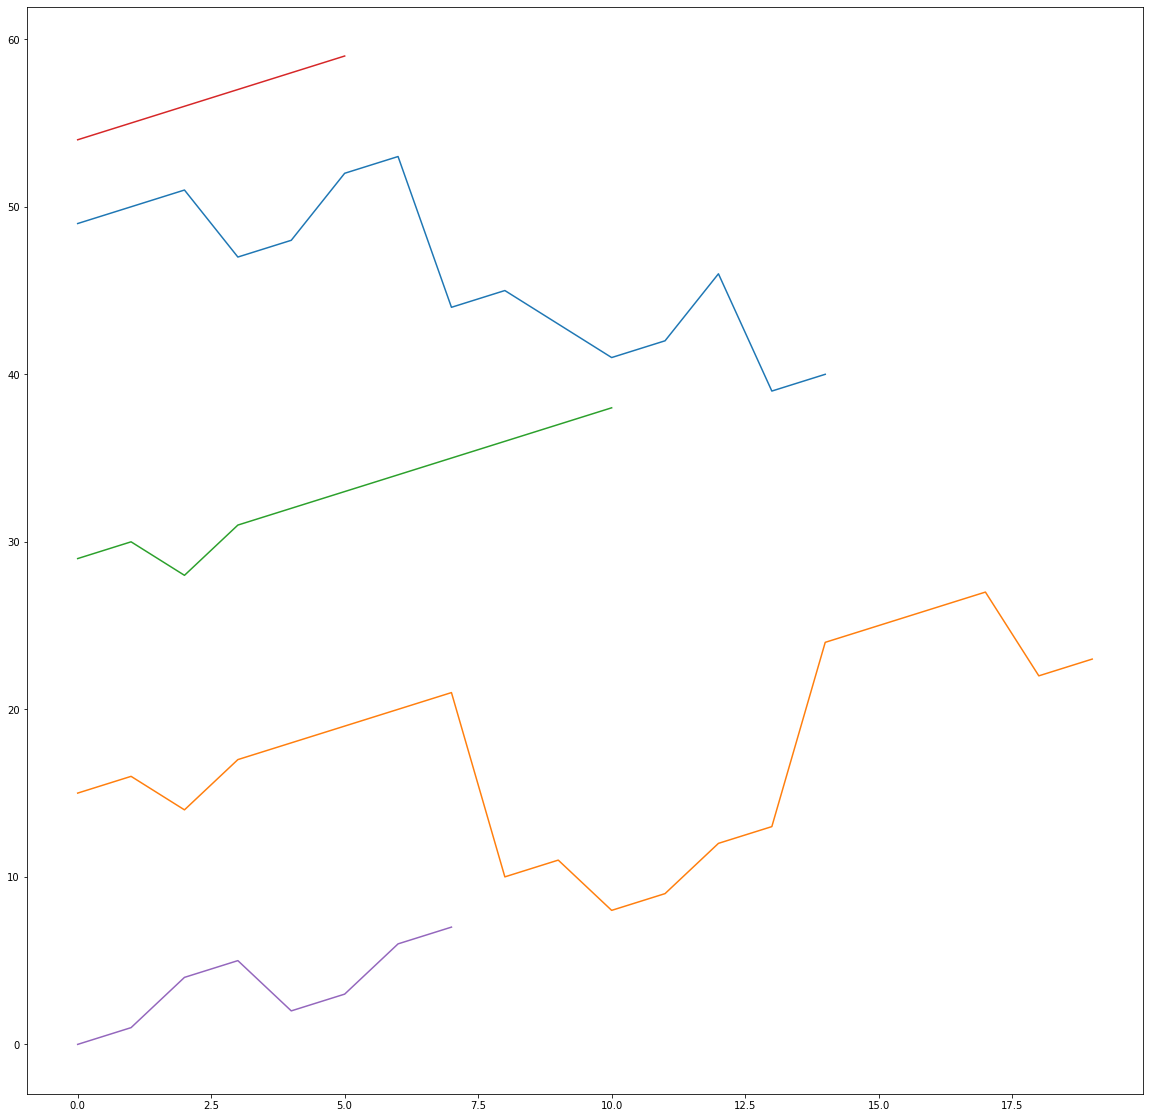

In [15]:
for row in ids:
    plt.plot(row)

In [35]:
ids, c_sizes

(array([array([49, 50, 51, 47, 48, 52, 53, 44, 45, 43, 41, 42, 46, 39, 40]),
        array([15, 16, 14, 17, 18, 19, 20, 21, 10, 11,  8,  9, 12, 13, 24, 25, 26,
               27, 22, 23])                                                       ,
        array([29, 30, 28, 31, 32, 33, 34, 35, 36, 37, 38]),
        array([54, 55, 56, 57, 58, 59]), array([0, 1, 4, 5, 2, 3, 6, 7])],
       dtype=object),
 array([15, 20, 11,  6,  8]))

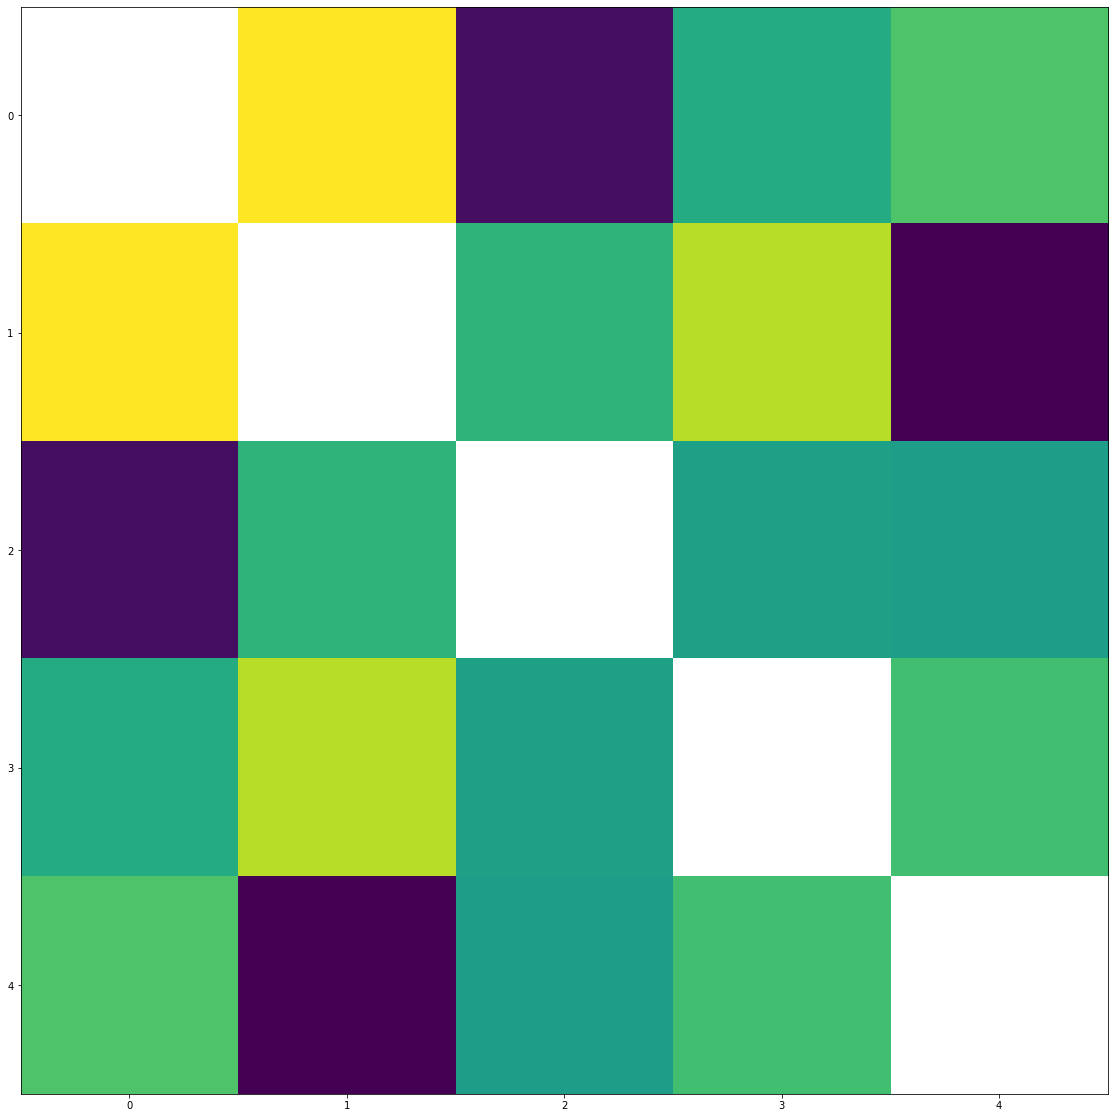

In [37]:
plt.imshow(distances)

In [38]:
#https://stackoverflow.com/questions/22927181/selecting-specific-rows-and-columns-from-numpy-array
#np.ix_(otherclusters_ids.ravel(), otherclusters_ids.ravel())